<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [ ]:
### Delete dataset exists
import os

folder_path = "./LITS17"
os.system(f"rm -rf {folder_path}")

0

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 397 (delta 115), reused 96 (delta 51), pack-reused 223 (from 1)
Receiving objects: 100% (397/397), 2.31 MiB | 5.93 MiB/s, done.
Resolving deltas: 100% (238/238), done.


In [2]:
from kltn.init.install_dependencies import install_packages
install_packages("./kltn")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import EDiceLoss, EDiceLoss_Val
from kltn.models import unet3d, unet3d_cot, unet3d_cot_da, unet3d_rescot_da
from kltn.utils.visualize_results import visualize_results
from kltn.utils.hd95_metrics import calc_hd95

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [5]:
log_path = "/content/drive/MyDrive/KLTN/logs"
LOGGER = init_logger(log_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS()

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
1.27% complete (down: 16542.4 kB/s up: 504.3 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.ph

## Load data

In [7]:
source_folder = "/content/LITS17"
full_train_dataset, val_dataset = get_datasets_lits(source_folder=source_folder, seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [8]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [9]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 3, 128, 128, 128])


## Visual data

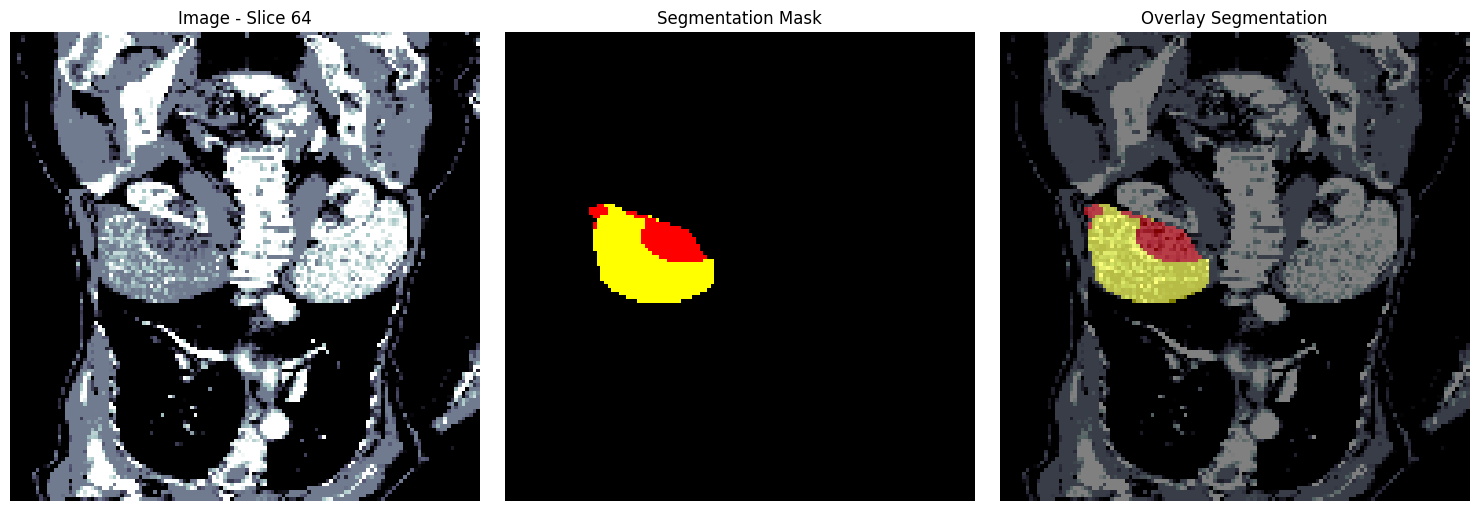

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]  
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 3, 128, 128, 128]

    slice_idx = image_sample.shape[2] // 2

    img_slice = image_sample[0, 0, slice_idx, :, :].numpy()
    label_slice = label_sample[0, :, slice_idx, :, :].argmax(0).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")


    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")


    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break  

## Model

In [10]:
model = unet3d.UNet3D(in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 2512515


## Training

In [11]:
start_epoch = 1
max_epochs = 50 # 100
batch_size = 1
val_every = 1

criterion = EDiceLoss().to(device)
criterion_val = EDiceLoss_Val().to(device)
metric = criterion_val.metric

# loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)


# dice_acc = DiceMetric(include_background=False, reduction='none', get_not_nans=True)
dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
path_save_model = "/content/drive/MyDrive/KLTN/code/weight"

In [ ]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(val_acc_max, best_epoch, dices_liver, dices_tumor, dices_avg, loss_epochs, trains_epoch
) = trainer(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer,
    loss_func = criterion,
    acc_func = dice_acc,
    criterion_val = criterion_val,
    metric = metric,
    scheduler = scheduler,
    batch_size = batch_size,
    max_epochs = max_epochs,
    start_epoch = start_epoch,
    val_every = val_every,
    path_save_model = path_save_model,
    logger = LOGGER,
    )

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/50 1/105 loss: 0.7968 time 10.55s
Epoch 1/50 2/105 loss: 0.7571 time 6.46s
Epoch 1/50 3/105 loss: 0.7351 time 5.61s
Epoch 1/50 4/105 loss: 0.7197 time 3.09s
Epoch 1/50 5/105 loss: 0.7065 time 14.28s
Epoch 1/50 6/105 loss: 0.6963 time 1.63s
Epoch 1/50 7/105 loss: 0.6889 time 2.49s
Epoch 1/50 8/105 loss: 0.6830 time 2.13s
Epoch 1/50 9/105 loss: 0.6776 time 9.17s
Epoch 1/50 10/105 loss: 0.6744 time 1.40s
Epoch 1/50 11/105 loss: 0.6708 time 9.02s
Epoch 1/50 12/105 loss: 0.6673 time 1.82s
Epoch 1/50 13/105 loss: 0.6653 time 1.53s
Epoch 1/50 14/105 loss: 0.6624 time 6.81s
Epoch 1/50 15/105 loss: 0.6596 time 10.95s
Epoch 1/50 16/105 loss: 0.6570 time 9.54s
Epoch 1/50 17/105 loss: 0.6546 time 10.40s
Epoch 1/50 18/105 loss: 0.6523 time 14.39s
Epoch 1/50 19/105 loss: 0.6501 time 14.49s
Epoch 1/50 20/105 loss: 0.6479 time 4.78s
Epoch 1/50 21/105 loss: 0.6461 time 7.45s
Epoch 1/50 22/105 loss: 0.6444 time 1.90s
Epoch 1/50 23/105 loss: 0.6427 time 10.08s
Epoch 1/50 24/105 loss: 0.6409 time 

Final training epochs: 1/50 ---[loss: 0.5676] ---[time 676.85s]
INFO:kltn.utils.logger:Final training epochs: 1/50 ---[loss: 0.5676] ---[time 676.85s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/50 105/105 loss: 0.5676 time 10.09s


Val 1/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.20s
INFO:kltn.utils.logger:Val 1/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.20s
Val 1/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.38s
INFO:kltn.utils.logger:Val 1/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.38s
Val 1/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.58s
INFO:kltn.utils.logger:Val 1/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.58s
Val 1/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.71s
INFO:kltn.utils.logger:Val 1/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.71s
Val 1/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.37s
INFO:kltn.utils.logger:Val 1/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.0362

New best (0.000000 --> 0.031637). At epoch 1



==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/50 1/105 loss: 0.5251 time 10.27s
Epoch 2/50 2/105 loss: 0.5160 time 14.76s
Epoch 2/50 3/105 loss: 0.5251 time 3.00s
Epoch 2/50 4/105 loss: 0.5155 time 11.86s
Epoch 2/50 5/105 loss: 0.5109 time 1.94s
Epoch 2/50 6/105 loss: 0.5058 time 10.10s
Epoch 2/50 7/105 loss: 0.5023 time 10.48s
Epoch 2/50 8/105 loss: 0.5008 time 2.85s
Epoch 2/50 9/105 loss: 0.4994 time 11.94s
Epoch 2/50 10/105 loss: 0.4974 time 1.76s
Epoch 2/50 11/105 loss: 0.4961 time 6.12s
Epoch 2/50 12/105 loss: 0.4953 time 8.87s
Epoch 2/50 13/105 loss: 0.4983 time 7.39s
Epoch 2/50 14/105 loss: 0.4961 time 7.05s
Epoch 2/50 15/105 loss: 0.4947 time 5.77s
Epoch 2/50 16/105 loss: 0.4957 time 1.28s
Epoch 2/50 17/105 loss: 0.4961 time 7.37s
Epoch 2/50 18/105 loss: 0.4949 time 10.04s
Epoch 2/50 19/105 loss: 0.4937 time 6.93s
Epoch 2/50 20/105 loss: 0.4925 time 1.29s
Epoch 2/50 21/105 loss: 0.4923 time 12.35s
Epoch 2/50 22/105 loss: 0.4902 time 2.11s
Epoch 2/50 23/105 loss: 0.4917 time 8.33s
Epoch 2/50 24/105 loss: 0.4910 time

Final training epochs: 2/50 ---[loss: 0.4875] ---[time 667.45s]
INFO:kltn.utils.logger:Final training epochs: 2/50 ---[loss: 0.4875] ---[time 667.45s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/50 105/105 loss: 0.4875 time 2.61s


Val 2/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.77s
INFO:kltn.utils.logger:Val 2/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.77s
Val 2/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.88s
INFO:kltn.utils.logger:Val 2/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.88s
Val 2/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.80s
INFO:kltn.utils.logger:Val 2/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.80s
Val 2/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.45s
INFO:kltn.utils.logger:Val 2/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.45s
Val 2/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.04s
INFO:kltn.utils.logger:Val 2/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.0362

Epoch 3/50 1/105 loss: 0.4620 time 8.55s
Epoch 3/50 2/105 loss: 0.4665 time 3.15s
Epoch 3/50 3/105 loss: 0.4727 time 7.07s
Epoch 3/50 4/105 loss: 0.4660 time 7.35s
Epoch 3/50 5/105 loss: 0.4635 time 2.67s
Epoch 3/50 6/105 loss: 0.4636 time 14.48s
Epoch 3/50 7/105 loss: 0.4664 time 7.83s
Epoch 3/50 8/105 loss: 0.4639 time 4.23s
Epoch 3/50 9/105 loss: 0.4646 time 9.20s
Epoch 3/50 10/105 loss: 0.4653 time 1.74s
Epoch 3/50 11/105 loss: 0.4657 time 8.84s
Epoch 3/50 12/105 loss: 0.4655 time 10.32s
Epoch 3/50 13/105 loss: 0.4652 time 1.18s
Epoch 3/50 14/105 loss: 0.4662 time 9.58s
Epoch 3/50 15/105 loss: 0.4657 time 11.46s
Epoch 3/50 16/105 loss: 0.4654 time 10.83s
Epoch 3/50 17/105 loss: 0.4649 time 1.48s
Epoch 3/50 18/105 loss: 0.4639 time 2.74s
Epoch 3/50 19/105 loss: 0.4676 time 2.81s
Epoch 3/50 20/105 loss: 0.4673 time 9.96s
Epoch 3/50 21/105 loss: 0.4670 time 2.18s
Epoch 3/50 22/105 loss: 0.4706 time 13.40s
Epoch 3/50 23/105 loss: 0.4683 time 5.79s
Epoch 3/50 24/105 loss: 0.4691 time 7.

Final training epochs: 3/50 ---[loss: 0.4682] ---[time 670.50s]
INFO:kltn.utils.logger:Final training epochs: 3/50 ---[loss: 0.4682] ---[time 670.50s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/50 105/105 loss: 0.4682 time 9.62s


Val 3/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.52s
INFO:kltn.utils.logger:Val 3/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.52s
Val 3/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.87s
INFO:kltn.utils.logger:Val 3/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.87s
Val 3/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.64s
INFO:kltn.utils.logger:Val 3/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.64s
Val 3/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.37s
INFO:kltn.utils.logger:Val 3/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.37s
Val 3/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.07s
INFO:kltn.utils.logger:Val 3/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.0362

Epoch 4/50 1/105 loss: 0.4821 time 13.27s
Epoch 4/50 2/105 loss: 0.4803 time 11.38s
Epoch 4/50 3/105 loss: 0.4663 time 3.28s
Epoch 4/50 4/105 loss: 0.4699 time 6.09s
Epoch 4/50 5/105 loss: 0.4647 time 2.60s
Epoch 4/50 6/105 loss: 0.4603 time 12.03s
Epoch 4/50 7/105 loss: 0.4557 time 2.80s
Epoch 4/50 8/105 loss: 0.4497 time 8.60s
Epoch 4/50 9/105 loss: 0.4508 time 8.67s
Epoch 4/50 10/105 loss: 0.4457 time 5.14s
Epoch 4/50 11/105 loss: 0.4419 time 4.65s
Epoch 4/50 12/105 loss: 0.4380 time 8.65s
Epoch 4/50 13/105 loss: 0.4365 time 10.70s
Epoch 4/50 14/105 loss: 0.4351 time 10.50s
Epoch 4/50 15/105 loss: 0.4332 time 6.83s
Epoch 4/50 16/105 loss: 0.4380 time 7.48s
Epoch 4/50 17/105 loss: 0.4414 time 10.77s
Epoch 4/50 18/105 loss: 0.4447 time 6.13s
Epoch 4/50 19/105 loss: 0.4471 time 10.59s
Epoch 4/50 20/105 loss: 0.4477 time 2.62s
Epoch 4/50 21/105 loss: 0.4452 time 8.04s
Epoch 4/50 22/105 loss: 0.4497 time 2.82s
Epoch 4/50 23/105 loss: 0.4483 time 11.42s
Epoch 4/50 24/105 loss: 0.4479 time

Final training epochs: 4/50 ---[loss: 0.4256] ---[time 659.07s]
INFO:kltn.utils.logger:Final training epochs: 4/50 ---[loss: 0.4256] ---[time 659.07s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/50 105/105 loss: 0.4256 time 9.86s


Val 4/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 6.60s
INFO:kltn.utils.logger:Val 4/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 6.60s
Val 4/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.87s
INFO:kltn.utils.logger:Val 4/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.87s
Val 4/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 3.11s
INFO:kltn.utils.logger:Val 4/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 3.11s
Val 4/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.41s
INFO:kltn.utils.logger:Val 4/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.41s
Val 4/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.06s
INFO:kltn.utils.logger:Val 4/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.0362

Epoch 5/50 1/105 loss: 0.3308 time 1.95s
Epoch 5/50 2/105 loss: 0.3438 time 11.25s
Epoch 5/50 3/105 loss: 0.3632 time 1.31s
Epoch 5/50 4/105 loss: 0.3694 time 10.88s
Epoch 5/50 5/105 loss: 0.3739 time 7.83s
Epoch 5/50 6/105 loss: 0.3720 time 1.80s
Epoch 5/50 7/105 loss: 0.3768 time 1.22s
Epoch 5/50 8/105 loss: 0.3963 time 2.83s
Epoch 5/50 9/105 loss: 0.3942 time 1.43s
Epoch 5/50 10/105 loss: 0.4062 time 3.10s
Epoch 5/50 11/105 loss: 0.4058 time 8.58s
Epoch 5/50 12/105 loss: 0.4041 time 10.70s
Epoch 5/50 13/105 loss: 0.4025 time 10.82s
Epoch 5/50 14/105 loss: 0.4015 time 4.95s
Epoch 5/50 15/105 loss: 0.3995 time 5.86s
Epoch 5/50 16/105 loss: 0.3980 time 9.15s
Epoch 5/50 17/105 loss: 0.3953 time 12.69s
Epoch 5/50 18/105 loss: 0.3931 time 8.70s
Epoch 5/50 19/105 loss: 0.3925 time 1.65s
Epoch 5/50 20/105 loss: 0.3914 time 4.46s
Epoch 5/50 21/105 loss: 0.3896 time 5.50s
Epoch 5/50 22/105 loss: 0.3895 time 2.17s
Epoch 5/50 23/105 loss: 0.3889 time 1.05s
Epoch 5/50 24/105 loss: 0.3880 time 2.

Final training epochs: 5/50 ---[loss: 0.3910] ---[time 667.75s]
INFO:kltn.utils.logger:Final training epochs: 5/50 ---[loss: 0.3910] ---[time 667.75s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/50 105/105 loss: 0.3910 time 10.17s


Val 5/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 6.46s
INFO:kltn.utils.logger:Val 5/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 6.46s
Val 5/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.16s
INFO:kltn.utils.logger:Val 5/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.16s
Val 5/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.61s
INFO:kltn.utils.logger:Val 5/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.61s
Val 5/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.38s
INFO:kltn.utils.logger:Val 5/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.38s
Val 5/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.07s
INFO:kltn.utils.logger:Val 5/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.0362

Epoch 6/50 1/105 loss: 0.3551 time 1.96s
Epoch 6/50 2/105 loss: 0.4327 time 4.14s
Epoch 6/50 3/105 loss: 0.3978 time 11.46s
Epoch 6/50 4/105 loss: 0.3903 time 5.83s
Epoch 6/50 5/105 loss: 0.3814 time 9.51s
Epoch 6/50 6/105 loss: 0.3746 time 2.96s
Epoch 6/50 7/105 loss: 0.3698 time 1.22s
Epoch 6/50 8/105 loss: 0.3777 time 1.35s
Epoch 6/50 9/105 loss: 0.3753 time 5.53s
Epoch 6/50 10/105 loss: 0.3721 time 14.34s
Epoch 6/50 11/105 loss: 0.3847 time 12.31s
Epoch 6/50 12/105 loss: 0.3844 time 6.43s
Epoch 6/50 13/105 loss: 0.3805 time 12.77s
Epoch 6/50 14/105 loss: 0.3788 time 8.81s
Epoch 6/50 15/105 loss: 0.3769 time 9.93s
Epoch 6/50 16/105 loss: 0.3884 time 3.19s
Epoch 6/50 17/105 loss: 0.3854 time 9.79s
Epoch 6/50 18/105 loss: 0.3940 time 3.22s
Epoch 6/50 19/105 loss: 0.3914 time 8.50s
Epoch 6/50 20/105 loss: 0.3921 time 0.91s
Epoch 6/50 21/105 loss: 0.3913 time 2.82s
Epoch 6/50 22/105 loss: 0.3887 time 1.23s
Epoch 6/50 23/105 loss: 0.3895 time 2.82s
Epoch 6/50 24/105 loss: 0.3880 time 4.3

Final training epochs: 6/50 ---[loss: 0.3709] ---[time 647.72s]
INFO:kltn.utils.logger:Final training epochs: 6/50 ---[loss: 0.3709] ---[time 647.72s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/50 105/105 loss: 0.3709 time 1.65s


Val 6/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 6.72s
INFO:kltn.utils.logger:Val 6/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 6.72s
Val 6/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.19s
INFO:kltn.utils.logger:Val 6/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.19s
Val 6/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.82s
INFO:kltn.utils.logger:Val 6/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.82s
Val 6/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.37s
INFO:kltn.utils.logger:Val 6/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.37s
Val 6/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.06s
INFO:kltn.utils.logger:Val 6/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.0362

Epoch 7/50 1/105 loss: 0.3689 time 2.83s
Epoch 7/50 2/105 loss: 0.3684 time 10.58s
Epoch 7/50 3/105 loss: 0.3621 time 14.86s
Epoch 7/50 4/105 loss: 0.3576 time 1.55s
Epoch 7/50 5/105 loss: 0.3469 time 1.27s
Epoch 7/50 6/105 loss: 0.3451 time 1.19s
Epoch 7/50 7/105 loss: 0.3714 time 5.18s
Epoch 7/50 8/105 loss: 0.3630 time 4.31s
Epoch 7/50 9/105 loss: 0.3744 time 3.91s
Epoch 7/50 10/105 loss: 0.3726 time 6.16s
Epoch 7/50 11/105 loss: 0.3652 time 8.58s
Epoch 7/50 12/105 loss: 0.3673 time 2.65s
Epoch 7/50 13/105 loss: 0.3717 time 6.79s
Epoch 7/50 14/105 loss: 0.3695 time 11.16s
Epoch 7/50 15/105 loss: 0.3690 time 5.97s
Epoch 7/50 16/105 loss: 0.3695 time 1.25s
Epoch 7/50 17/105 loss: 0.3672 time 8.83s
Epoch 7/50 18/105 loss: 0.3663 time 5.04s
Epoch 7/50 19/105 loss: 0.3748 time 1.82s
Epoch 7/50 20/105 loss: 0.3726 time 10.84s
Epoch 7/50 21/105 loss: 0.3712 time 6.35s
Epoch 7/50 22/105 loss: 0.3690 time 6.39s
Epoch 7/50 23/105 loss: 0.3680 time 1.33s
Epoch 7/50 24/105 loss: 0.3686 time 1.8

Final training epochs: 7/50 ---[loss: 0.3688] ---[time 662.66s]
INFO:kltn.utils.logger:Final training epochs: 7/50 ---[loss: 0.3688] ---[time 662.66s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/50 105/105 loss: 0.3688 time 13.83s


Val 7/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 5.54s
INFO:kltn.utils.logger:Val 7/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 5.54s
Val 7/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.86s
INFO:kltn.utils.logger:Val 7/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.86s
Val 7/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.79s
INFO:kltn.utils.logger:Val 7/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.79s
Val 7/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.71s
INFO:kltn.utils.logger:Val 7/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.71s
Val 7/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.04s
INFO:kltn.utils.logger:Val 7/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.0362

Epoch 8/50 1/105 loss: 0.4524 time 1.51s
Epoch 8/50 2/105 loss: 0.4007 time 14.27s
Epoch 8/50 3/105 loss: 0.3985 time 8.04s
Epoch 8/50 4/105 loss: 0.4294 time 4.04s
Epoch 8/50 5/105 loss: 0.4116 time 7.17s
Epoch 8/50 6/105 loss: 0.4161 time 1.49s
Epoch 8/50 7/105 loss: 0.4042 time 3.10s
Epoch 8/50 8/105 loss: 0.3950 time 6.55s
Epoch 8/50 9/105 loss: 0.3884 time 1.50s
Epoch 8/50 10/105 loss: 0.3836 time 14.29s
Epoch 8/50 11/105 loss: 0.3773 time 6.83s
Epoch 8/50 12/105 loss: 0.3736 time 8.31s
Epoch 8/50 13/105 loss: 0.3714 time 9.36s
Epoch 8/50 14/105 loss: 0.3680 time 2.57s
Epoch 8/50 15/105 loss: 0.3659 time 8.01s
Epoch 8/50 16/105 loss: 0.3649 time 9.24s
Epoch 8/50 17/105 loss: 0.3634 time 9.33s
Epoch 8/50 18/105 loss: 0.3612 time 7.34s
Epoch 8/50 19/105 loss: 0.3601 time 2.43s
Epoch 8/50 20/105 loss: 0.3618 time 13.81s
Epoch 8/50 21/105 loss: 0.3691 time 2.46s
Epoch 8/50 22/105 loss: 0.3667 time 2.66s
Epoch 8/50 23/105 loss: 0.3640 time 11.52s
Epoch 8/50 24/105 loss: 0.3626 time 10.

Final training epochs: 8/50 ---[loss: 0.3577] ---[time 655.68s]
INFO:kltn.utils.logger:Final training epochs: 8/50 ---[loss: 0.3577] ---[time 655.68s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/50 105/105 loss: 0.3577 time 1.81s


Val 8/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.13s
INFO:kltn.utils.logger:Val 8/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.13s
Val 8/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.91s
INFO:kltn.utils.logger:Val 8/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.91s
Val 8/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.72s
INFO:kltn.utils.logger:Val 8/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.72s
Val 8/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.38s
INFO:kltn.utils.logger:Val 8/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.38s
Val 8/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.09s
INFO:kltn.utils.logger:Val 8/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.0362

Epoch 9/50 1/105 loss: 0.3286 time 13.00s
Epoch 9/50 2/105 loss: 0.3277 time 2.82s
Epoch 9/50 3/105 loss: 0.3472 time 12.89s
Epoch 9/50 4/105 loss: 0.3532 time 7.87s
Epoch 9/50 5/105 loss: 0.3451 time 12.33s
Epoch 9/50 6/105 loss: 0.3448 time 1.63s
Epoch 9/50 7/105 loss: 0.3483 time 8.72s
Epoch 9/50 8/105 loss: 0.3451 time 11.22s
Epoch 9/50 9/105 loss: 0.3398 time 4.52s
Epoch 9/50 10/105 loss: 0.3416 time 10.48s
Epoch 9/50 11/105 loss: 0.3385 time 5.39s
Epoch 9/50 12/105 loss: 0.3410 time 2.88s
Epoch 9/50 13/105 loss: 0.3436 time 6.96s
Epoch 9/50 14/105 loss: 0.3411 time 6.17s
Epoch 9/50 15/105 loss: 0.3399 time 8.52s
Epoch 9/50 16/105 loss: 0.3404 time 12.45s
Epoch 9/50 17/105 loss: 0.3393 time 1.83s
Epoch 9/50 18/105 loss: 0.3431 time 2.05s
Epoch 9/50 19/105 loss: 0.3432 time 5.47s
Epoch 9/50 20/105 loss: 0.3447 time 1.23s
Epoch 9/50 21/105 loss: 0.3480 time 2.91s
Epoch 9/50 22/105 loss: 0.3467 time 4.38s
Epoch 9/50 23/105 loss: 0.3457 time 10.02s
Epoch 9/50 24/105 loss: 0.3481 time 

Final training epochs: 9/50 ---[loss: 0.3460] ---[time 658.97s]
INFO:kltn.utils.logger:Final training epochs: 9/50 ---[loss: 0.3460] ---[time 658.97s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/50 105/105 loss: 0.3460 time 9.39s


Val 9/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.35s
INFO:kltn.utils.logger:Val 9/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.35s
Val 9/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.87s
INFO:kltn.utils.logger:Val 9/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 0.87s
Val 9/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.60s
INFO:kltn.utils.logger:Val 9/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.60s
Val 9/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.37s
INFO:kltn.utils.logger:Val 9/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.37s
Val 9/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.07s
INFO:kltn.utils.logger:Val 9/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.0362

Epoch 10/50 1/105 loss: 0.2842 time 12.98s
Epoch 10/50 2/105 loss: 0.3193 time 8.66s
Epoch 10/50 3/105 loss: 0.3332 time 2.03s
Epoch 10/50 4/105 loss: 0.3438 time 2.53s
Epoch 10/50 5/105 loss: 0.3378 time 5.54s
Epoch 10/50 6/105 loss: 0.3344 time 1.21s
Epoch 10/50 7/105 loss: 0.3427 time 3.00s
Epoch 10/50 8/105 loss: 0.3383 time 10.45s
Epoch 10/50 9/105 loss: 0.3415 time 10.36s
Epoch 10/50 10/105 loss: 0.3368 time 5.76s
Epoch 10/50 11/105 loss: 0.3525 time 3.52s
Epoch 10/50 12/105 loss: 0.3568 time 1.33s
Epoch 10/50 13/105 loss: 0.3534 time 9.48s
Epoch 10/50 14/105 loss: 0.3533 time 10.05s
Epoch 10/50 15/105 loss: 0.3526 time 2.96s
Epoch 10/50 16/105 loss: 0.3494 time 4.40s
Epoch 10/50 17/105 loss: 0.3461 time 7.94s
Epoch 10/50 18/105 loss: 0.3473 time 7.15s
Epoch 10/50 19/105 loss: 0.3528 time 13.74s
Epoch 10/50 20/105 loss: 0.3526 time 14.29s
Epoch 10/50 21/105 loss: 0.3509 time 1.90s
Epoch 10/50 22/105 loss: 0.3514 time 3.83s
Epoch 10/50 23/105 loss: 0.3550 time 4.73s
Epoch 10/50 24

Final training epochs: 10/50 ---[loss: 0.3417] ---[time 648.34s]
INFO:kltn.utils.logger:Final training epochs: 10/50 ---[loss: 0.3417] ---[time 648.34s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/50 105/105 loss: 0.3417 time 10.20s


Val 10/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.23s
INFO:kltn.utils.logger:Val 10/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.23s
Val 10/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.79s
INFO:kltn.utils.logger:Val 10/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.79s
Val 10/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.58s
INFO:kltn.utils.logger:Val 10/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.58s
Val 10/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.38s
INFO:kltn.utils.logger:Val 10/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.38s
Val 10/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.08s
INFO:kltn.utils.logger:Val 10/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_A

Epoch 11/50 1/105 loss: 0.3126 time 2.61s
Epoch 11/50 2/105 loss: 0.3274 time 2.83s
Epoch 11/50 3/105 loss: 0.3220 time 13.10s
Epoch 11/50 4/105 loss: 0.3212 time 2.30s
Epoch 11/50 5/105 loss: 0.3175 time 6.21s
Epoch 11/50 6/105 loss: 0.3227 time 11.22s
Epoch 11/50 7/105 loss: 0.3176 time 7.17s
Epoch 11/50 8/105 loss: 0.3176 time 11.04s
Epoch 11/50 9/105 loss: 0.3170 time 3.27s
Epoch 11/50 10/105 loss: 0.3167 time 10.46s
Epoch 11/50 11/105 loss: 0.3232 time 3.34s
Epoch 11/50 12/105 loss: 0.3226 time 9.03s
Epoch 11/50 13/105 loss: 0.3261 time 2.86s
Epoch 11/50 14/105 loss: 0.3259 time 11.12s
Epoch 11/50 15/105 loss: 0.3310 time 2.05s
Epoch 11/50 16/105 loss: 0.3324 time 3.04s
Epoch 11/50 17/105 loss: 0.3301 time 6.24s
Epoch 11/50 18/105 loss: 0.3278 time 7.35s
Epoch 11/50 19/105 loss: 0.3295 time 10.73s
Epoch 11/50 20/105 loss: 0.3296 time 7.20s
Epoch 11/50 21/105 loss: 0.3300 time 12.89s
Epoch 11/50 22/105 loss: 0.3299 time 3.42s
Epoch 11/50 23/105 loss: 0.3318 time 5.06s
Epoch 11/50 2

Final training epochs: 11/50 ---[loss: 0.3287] ---[time 648.83s]
INFO:kltn.utils.logger:Final training epochs: 11/50 ---[loss: 0.3287] ---[time 648.83s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/50 105/105 loss: 0.3287 time 8.98s


Val 11/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.86s
INFO:kltn.utils.logger:Val 11/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.86s
Val 11/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.27s
INFO:kltn.utils.logger:Val 11/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.27s
Val 11/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.61s
INFO:kltn.utils.logger:Val 11/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.61s
Val 11/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.40s
INFO:kltn.utils.logger:Val 11/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.40s
Val 11/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.46s
INFO:kltn.utils.logger:Val 11/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_A

Epoch 12/50 1/105 loss: 0.3068 time 16.18s
Epoch 12/50 2/105 loss: 0.3103 time 13.05s
Epoch 12/50 3/105 loss: 0.3096 time 6.62s
Epoch 12/50 4/105 loss: 0.3057 time 8.62s
Epoch 12/50 5/105 loss: 0.3006 time 6.67s
Epoch 12/50 6/105 loss: 0.2989 time 6.85s
Epoch 12/50 7/105 loss: 0.3133 time 1.35s
Epoch 12/50 8/105 loss: 0.3137 time 10.99s
Epoch 12/50 9/105 loss: 0.3201 time 3.08s
Epoch 12/50 10/105 loss: 0.3181 time 9.66s
Epoch 12/50 11/105 loss: 0.3166 time 4.92s
Epoch 12/50 12/105 loss: 0.3177 time 9.90s
Epoch 12/50 13/105 loss: 0.3195 time 2.77s
Epoch 12/50 14/105 loss: 0.3187 time 6.67s
Epoch 12/50 15/105 loss: 0.3187 time 2.81s
Epoch 12/50 16/105 loss: 0.3171 time 2.15s
Epoch 12/50 17/105 loss: 0.3169 time 1.23s
Epoch 12/50 18/105 loss: 0.3176 time 10.56s
Epoch 12/50 19/105 loss: 0.3191 time 2.77s
Epoch 12/50 20/105 loss: 0.3200 time 1.21s
Epoch 12/50 21/105 loss: 0.3196 time 10.42s
Epoch 12/50 22/105 loss: 0.3179 time 7.53s
Epoch 12/50 23/105 loss: 0.3199 time 9.54s
Epoch 12/50 24/

Final training epochs: 12/50 ---[loss: 0.3291] ---[time 666.59s]
INFO:kltn.utils.logger:Final training epochs: 12/50 ---[loss: 0.3291] ---[time 666.59s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/50 105/105 loss: 0.3291 time 11.84s


Val 12/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.65s
INFO:kltn.utils.logger:Val 12/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 7.65s
Val 12/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.27s
INFO:kltn.utils.logger:Val 12/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.27s
Val 12/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.63s
INFO:kltn.utils.logger:Val 12/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.63s
Val 12/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.37s
INFO:kltn.utils.logger:Val 12/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.37s
Val 12/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.09s
INFO:kltn.utils.logger:Val 12/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_A

Epoch 13/50 1/105 loss: 0.2870 time 2.09s
Epoch 13/50 2/105 loss: 0.2953 time 1.51s
Epoch 13/50 3/105 loss: 0.2998 time 9.77s
Epoch 13/50 4/105 loss: 0.2989 time 12.11s
Epoch 13/50 5/105 loss: 0.3095 time 6.65s
Epoch 13/50 6/105 loss: 0.3084 time 12.49s
Epoch 13/50 7/105 loss: 0.3186 time 5.64s
Epoch 13/50 8/105 loss: 0.3220 time 2.84s
Epoch 13/50 9/105 loss: 0.3214 time 5.15s
Epoch 13/50 10/105 loss: 0.3211 time 9.38s
Epoch 13/50 11/105 loss: 0.3207 time 8.47s
Epoch 13/50 12/105 loss: 0.3195 time 1.22s
Epoch 13/50 13/105 loss: 0.3187 time 11.21s
Epoch 13/50 14/105 loss: 0.3212 time 1.75s
Epoch 13/50 15/105 loss: 0.3239 time 8.37s
Epoch 13/50 16/105 loss: 0.3221 time 6.55s
Epoch 13/50 17/105 loss: 0.3212 time 6.71s
Epoch 13/50 18/105 loss: 0.3234 time 14.06s
Epoch 13/50 19/105 loss: 0.3223 time 8.53s
Epoch 13/50 20/105 loss: 0.3222 time 1.61s
Epoch 13/50 21/105 loss: 0.3206 time 6.63s
Epoch 13/50 22/105 loss: 0.3195 time 2.15s
Epoch 13/50 23/105 loss: 0.3213 time 5.18s
Epoch 13/50 24/1

Final training epochs: 13/50 ---[loss: 0.3274] ---[time 656.15s]
INFO:kltn.utils.logger:Final training epochs: 13/50 ---[loss: 0.3274] ---[time 656.15s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/50 105/105 loss: 0.3274 time 2.38s


Val 13/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.97s
INFO:kltn.utils.logger:Val 13/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.97s
Val 13/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.59s
INFO:kltn.utils.logger:Val 13/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.59s
Val 13/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.87s
INFO:kltn.utils.logger:Val 13/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.87s
Val 13/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.45s
INFO:kltn.utils.logger:Val 13/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.45s
Val 13/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.44s
INFO:kltn.utils.logger:Val 13/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_A

Epoch 14/50 1/105 loss: 0.3277 time 2.77s
Epoch 14/50 2/105 loss: 0.3210 time 5.65s
Epoch 14/50 3/105 loss: 0.3131 time 2.62s
Epoch 14/50 4/105 loss: 0.3159 time 5.90s
Epoch 14/50 5/105 loss: 0.3137 time 12.49s
Epoch 14/50 6/105 loss: 0.3087 time 6.85s
Epoch 14/50 7/105 loss: 0.3109 time 4.75s
Epoch 14/50 8/105 loss: 0.3142 time 1.51s
Epoch 14/50 9/105 loss: 0.3106 time 7.63s
Epoch 14/50 10/105 loss: 0.3091 time 8.57s
Epoch 14/50 11/105 loss: 0.3109 time 10.20s
Epoch 14/50 12/105 loss: 0.3101 time 7.39s
Epoch 14/50 13/105 loss: 0.3098 time 9.82s
Epoch 14/50 14/105 loss: 0.3157 time 6.14s
Epoch 14/50 15/105 loss: 0.3137 time 10.16s
Epoch 14/50 16/105 loss: 0.3197 time 3.16s
Epoch 14/50 17/105 loss: 0.3185 time 9.97s
Epoch 14/50 18/105 loss: 0.3203 time 13.90s
Epoch 14/50 19/105 loss: 0.3200 time 2.97s
Epoch 14/50 20/105 loss: 0.3212 time 11.36s
Epoch 14/50 21/105 loss: 0.3214 time 9.62s
Epoch 14/50 22/105 loss: 0.3207 time 1.37s
Epoch 14/50 23/105 loss: 0.3199 time 10.10s
Epoch 14/50 24

Final training epochs: 14/50 ---[loss: 0.3187] ---[time 658.69s]
INFO:kltn.utils.logger:Final training epochs: 14/50 ---[loss: 0.3187] ---[time 658.69s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/50 105/105 loss: 0.3187 time 3.62s


Val 14/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.12s
INFO:kltn.utils.logger:Val 14/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.12s
Val 14/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.00s
INFO:kltn.utils.logger:Val 14/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.00s
Val 14/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.91s
INFO:kltn.utils.logger:Val 14/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.91s
Val 14/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.58s
INFO:kltn.utils.logger:Val 14/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.58s
Val 14/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.20s
INFO:kltn.utils.logger:Val 14/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_A

Epoch 15/50 1/105 loss: 0.3148 time 11.73s
Epoch 15/50 2/105 loss: 0.3077 time 7.17s
Epoch 15/50 3/105 loss: 0.3255 time 2.99s
Epoch 15/50 4/105 loss: 0.3177 time 4.14s
Epoch 15/50 5/105 loss: 0.3129 time 1.35s
Epoch 15/50 6/105 loss: 0.3153 time 4.43s
Epoch 15/50 7/105 loss: 0.3181 time 13.01s
Epoch 15/50 8/105 loss: 0.3181 time 9.46s
Epoch 15/50 9/105 loss: 0.3166 time 7.10s
Epoch 15/50 10/105 loss: 0.3213 time 1.29s
Epoch 15/50 11/105 loss: 0.3323 time 3.61s
Epoch 15/50 12/105 loss: 0.3291 time 5.00s
Epoch 15/50 13/105 loss: 0.3255 time 8.22s
Epoch 15/50 14/105 loss: 0.3254 time 1.63s
Epoch 15/50 15/105 loss: 0.3277 time 3.30s
Epoch 15/50 16/105 loss: 0.3296 time 11.06s
Epoch 15/50 17/105 loss: 0.3289 time 9.15s
Epoch 15/50 18/105 loss: 0.3307 time 2.19s
Epoch 15/50 19/105 loss: 0.3303 time 8.04s
Epoch 15/50 20/105 loss: 0.3288 time 7.47s
Epoch 15/50 21/105 loss: 0.3322 time 14.00s
Epoch 15/50 22/105 loss: 0.3309 time 2.73s
Epoch 15/50 23/105 loss: 0.3299 time 10.40s
Epoch 15/50 24/

Final training epochs: 15/50 ---[loss: 0.3212] ---[time 671.27s]
INFO:kltn.utils.logger:Final training epochs: 15/50 ---[loss: 0.3212] ---[time 671.27s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/50 105/105 loss: 0.3212 time 12.87s


Val 15/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.36s
INFO:kltn.utils.logger:Val 15/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.36s
Val 15/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.79s
INFO:kltn.utils.logger:Val 15/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.79s
Val 15/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.57s
INFO:kltn.utils.logger:Val 15/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.57s
Val 15/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.43s
INFO:kltn.utils.logger:Val 15/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.43s
Val 15/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.11s
INFO:kltn.utils.logger:Val 15/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_A

Epoch 16/50 1/105 loss: 0.3165 time 14.12s
Epoch 16/50 2/105 loss: 0.2983 time 7.07s
Epoch 16/50 3/105 loss: 0.2967 time 4.39s
Epoch 16/50 4/105 loss: 0.3000 time 10.83s
Epoch 16/50 5/105 loss: 0.3020 time 3.23s
Epoch 16/50 6/105 loss: 0.3057 time 9.36s
Epoch 16/50 7/105 loss: 0.3044 time 10.88s
Epoch 16/50 8/105 loss: 0.3032 time 6.37s
Epoch 16/50 9/105 loss: 0.3055 time 10.95s
Epoch 16/50 10/105 loss: 0.3129 time 5.84s
Epoch 16/50 11/105 loss: 0.3108 time 2.46s
Epoch 16/50 12/105 loss: 0.3092 time 2.55s
Epoch 16/50 13/105 loss: 0.3149 time 1.33s
Epoch 16/50 14/105 loss: 0.3135 time 11.09s
Epoch 16/50 15/105 loss: 0.3129 time 8.60s
Epoch 16/50 16/105 loss: 0.3134 time 9.67s
Epoch 16/50 17/105 loss: 0.3121 time 1.64s
Epoch 16/50 18/105 loss: 0.3118 time 4.74s
Epoch 16/50 19/105 loss: 0.3125 time 3.86s
Epoch 16/50 20/105 loss: 0.3146 time 12.91s
Epoch 16/50 21/105 loss: 0.3131 time 7.10s
Epoch 16/50 22/105 loss: 0.3125 time 10.32s
Epoch 16/50 23/105 loss: 0.3137 time 9.52s
Epoch 16/50 2

Final training epochs: 16/50 ---[loss: 0.3119] ---[time 669.17s]
INFO:kltn.utils.logger:Final training epochs: 16/50 ---[loss: 0.3119] ---[time 669.17s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/50 105/105 loss: 0.3119 time 4.31s


Val 16/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.05s
INFO:kltn.utils.logger:Val 16/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.05s
Val 16/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.79s
INFO:kltn.utils.logger:Val 16/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.79s
Val 16/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.74s
INFO:kltn.utils.logger:Val 16/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.74s
Val 16/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.48s
INFO:kltn.utils.logger:Val 16/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.48s
Val 16/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.11s
INFO:kltn.utils.logger:Val 16/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 17/50 1/105 loss: 0.2815 time 13.38s
Epoch 17/50 2/105 loss: 0.2846 time 2.01s
Epoch 17/50 3/105 loss: 0.2925 time 1.37s
Epoch 17/50 4/105 loss: 0.2936 time 6.29s
Epoch 17/50 5/105 loss: 0.2924 time 8.26s
Epoch 17/50 6/105 loss: 0.2939 time 11.50s
Epoch 17/50 7/105 loss: 0.2918 time 6.47s
Epoch 17/50 8/105 loss: 0.2915 time 14.02s
Epoch 17/50 9/105 loss: 0.2989 time 5.50s
Epoch 17/50 10/105 loss: 0.3006 time 5.13s
Epoch 17/50 11/105 loss: 0.3020 time 3.31s
Epoch 17/50 12/105 loss: 0.2999 time 7.03s
Epoch 17/50 13/105 loss: 0.2999 time 1.49s
Epoch 17/50 14/105 loss: 0.2979 time 8.21s
Epoch 17/50 15/105 loss: 0.2994 time 1.98s
Epoch 17/50 16/105 loss: 0.2995 time 9.49s
Epoch 17/50 17/105 loss: 0.3012 time 14.10s
Epoch 17/50 18/105 loss: 0.3011 time 2.45s
Epoch 17/50 19/105 loss: 0.3005 time 2.32s
Epoch 17/50 20/105 loss: 0.3019 time 4.86s
Epoch 17/50 21/105 loss: 0.3027 time 11.69s
Epoch 17/50 22/105 loss: 0.3028 time 2.29s
Epoch 17/50 23/105 loss: 0.3023 time 4.56s
Epoch 17/50 24/

Final training epochs: 17/50 ---[loss: 0.3108] ---[time 655.10s]
INFO:kltn.utils.logger:Final training epochs: 17/50 ---[loss: 0.3108] ---[time 655.10s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/50 105/105 loss: 0.3108 time 12.43s


Val 17/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.46s
INFO:kltn.utils.logger:Val 17/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.46s
Val 17/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.70s
INFO:kltn.utils.logger:Val 17/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.70s
Val 17/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.63s
INFO:kltn.utils.logger:Val 17/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.63s
Val 17/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.83s
INFO:kltn.utils.logger:Val 17/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.83s
Val 17/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.11s
INFO:kltn.utils.logger:Val 17/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_A

Epoch 18/50 1/105 loss: 0.2810 time 10.30s
Epoch 18/50 2/105 loss: 0.2900 time 3.16s
Epoch 18/50 3/105 loss: 0.3025 time 1.26s
Epoch 18/50 4/105 loss: 0.3019 time 1.12s
Epoch 18/50 5/105 loss: 0.3037 time 4.60s
Epoch 18/50 6/105 loss: 0.3158 time 1.28s
Epoch 18/50 7/105 loss: 0.3162 time 6.75s
Epoch 18/50 8/105 loss: 0.3175 time 11.34s
Epoch 18/50 9/105 loss: 0.3154 time 7.19s
Epoch 18/50 10/105 loss: 0.3140 time 9.62s
Epoch 18/50 11/105 loss: 0.3124 time 12.67s
Epoch 18/50 12/105 loss: 0.3097 time 11.87s
Epoch 18/50 13/105 loss: 0.3108 time 10.16s
Epoch 18/50 14/105 loss: 0.3106 time 10.26s
Epoch 18/50 15/105 loss: 0.3141 time 13.11s
Epoch 18/50 16/105 loss: 0.3140 time 2.87s
Epoch 18/50 17/105 loss: 0.3160 time 3.02s
Epoch 18/50 18/105 loss: 0.3152 time 7.64s
Epoch 18/50 19/105 loss: 0.3146 time 7.86s
Epoch 18/50 20/105 loss: 0.3133 time 4.83s
Epoch 18/50 21/105 loss: 0.3159 time 13.88s
Epoch 18/50 22/105 loss: 0.3150 time 1.52s
Epoch 18/50 23/105 loss: 0.3175 time 2.92s
Epoch 18/50 

Final training epochs: 18/50 ---[loss: 0.3109] ---[time 655.95s]
INFO:kltn.utils.logger:Final training epochs: 18/50 ---[loss: 0.3109] ---[time 655.95s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/50 105/105 loss: 0.3109 time 2.07s


Val 18/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.18s
INFO:kltn.utils.logger:Val 18/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.18s
Val 18/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.70s
INFO:kltn.utils.logger:Val 18/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.70s
Val 18/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.57s
INFO:kltn.utils.logger:Val 18/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.57s
Val 18/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.81s
INFO:kltn.utils.logger:Val 18/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.81s
Val 18/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.09s
INFO:kltn.utils.logger:Val 18/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_A

Epoch 19/50 1/105 loss: 0.3072 time 1.91s
Epoch 19/50 2/105 loss: 0.3104 time 12.91s
Epoch 19/50 3/105 loss: 0.3058 time 9.90s
Epoch 19/50 4/105 loss: 0.3015 time 2.31s
Epoch 19/50 5/105 loss: 0.3058 time 1.55s
Epoch 19/50 6/105 loss: 0.3086 time 2.72s
Epoch 19/50 7/105 loss: 0.3077 time 11.64s
Epoch 19/50 8/105 loss: 0.3110 time 13.45s
Epoch 19/50 9/105 loss: 0.3151 time 5.13s
Epoch 19/50 10/105 loss: 0.3160 time 0.91s
Epoch 19/50 11/105 loss: 0.3137 time 11.60s
Epoch 19/50 12/105 loss: 0.3127 time 2.88s
Epoch 19/50 13/105 loss: 0.3116 time 2.71s
Epoch 19/50 14/105 loss: 0.3123 time 4.42s
Epoch 19/50 15/105 loss: 0.3106 time 9.80s
Epoch 19/50 16/105 loss: 0.3096 time 2.37s
Epoch 19/50 17/105 loss: 0.3093 time 11.70s
Epoch 19/50 18/105 loss: 0.3092 time 9.15s
Epoch 19/50 19/105 loss: 0.3089 time 7.77s
Epoch 19/50 20/105 loss: 0.3078 time 4.96s
Epoch 19/50 21/105 loss: 0.3072 time 6.53s
Epoch 19/50 22/105 loss: 0.3072 time 1.33s
Epoch 19/50 23/105 loss: 0.3081 time 3.05s
Epoch 19/50 24/

Final training epochs: 19/50 ---[loss: 0.3079] ---[time 649.31s]
INFO:kltn.utils.logger:Final training epochs: 19/50 ---[loss: 0.3079] ---[time 649.31s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/50 105/105 loss: 0.3079 time 4.58s


Val 19/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.24s
INFO:kltn.utils.logger:Val 19/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.24s
Val 19/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.63s
INFO:kltn.utils.logger:Val 19/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.63s
Val 19/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.95s
INFO:kltn.utils.logger:Val 19/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.95s
Val 19/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.40s
INFO:kltn.utils.logger:Val 19/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.40s
Val 19/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.07s
INFO:kltn.utils.logger:Val 19/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_A

Epoch 20/50 1/105 loss: 0.3093 time 6.44s
Epoch 20/50 2/105 loss: 0.3062 time 5.22s
Epoch 20/50 3/105 loss: 0.3521 time 3.72s
Epoch 20/50 4/105 loss: 0.3379 time 13.06s
Epoch 20/50 5/105 loss: 0.3394 time 13.22s
Epoch 20/50 6/105 loss: 0.3387 time 11.38s
Epoch 20/50 7/105 loss: 0.3322 time 10.58s
Epoch 20/50 8/105 loss: 0.3293 time 8.42s
Epoch 20/50 9/105 loss: 0.3245 time 8.55s
Epoch 20/50 10/105 loss: 0.3216 time 2.82s
Epoch 20/50 11/105 loss: 0.3185 time 7.44s
Epoch 20/50 12/105 loss: 0.3166 time 6.28s
Epoch 20/50 13/105 loss: 0.3146 time 1.01s
Epoch 20/50 14/105 loss: 0.3148 time 3.59s
Epoch 20/50 15/105 loss: 0.3144 time 6.39s
Epoch 20/50 16/105 loss: 0.3136 time 9.90s
Epoch 20/50 17/105 loss: 0.3112 time 7.97s
Epoch 20/50 18/105 loss: 0.3113 time 1.89s
Epoch 20/50 19/105 loss: 0.3111 time 1.31s
Epoch 20/50 20/105 loss: 0.3114 time 11.84s
Epoch 20/50 21/105 loss: 0.3111 time 5.17s
Epoch 20/50 22/105 loss: 0.3107 time 8.46s
Epoch 20/50 23/105 loss: 0.3143 time 2.32s
Epoch 20/50 24/

Final training epochs: 20/50 ---[loss: 0.3058] ---[time 659.76s]
INFO:kltn.utils.logger:Final training epochs: 20/50 ---[loss: 0.3058] ---[time 659.76s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/50 105/105 loss: 0.3058 time 9.89s


Val 20/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.95s
INFO:kltn.utils.logger:Val 20/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.95s
Val 20/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.97s
INFO:kltn.utils.logger:Val 20/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.97s
Val 20/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.59s
INFO:kltn.utils.logger:Val 20/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.59s
Val 20/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.38s
INFO:kltn.utils.logger:Val 20/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.38s
Val 20/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.07s
INFO:kltn.utils.logger:Val 20/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 21/50 1/105 loss: 0.2826 time 3.29s
Epoch 21/50 2/105 loss: 0.2996 time 12.57s
Epoch 21/50 3/105 loss: 0.3041 time 3.56s
Epoch 21/50 4/105 loss: 0.2970 time 6.55s
Epoch 21/50 5/105 loss: 0.3085 time 2.88s
Epoch 21/50 6/105 loss: 0.3033 time 6.20s
Epoch 21/50 7/105 loss: 0.3014 time 1.51s
Epoch 21/50 8/105 loss: 0.3049 time 3.87s
Epoch 21/50 9/105 loss: 0.3038 time 2.22s
Epoch 21/50 10/105 loss: 0.3037 time 13.13s
Epoch 21/50 11/105 loss: 0.3050 time 1.85s
Epoch 21/50 12/105 loss: 0.3052 time 10.32s
Epoch 21/50 13/105 loss: 0.3037 time 1.67s
Epoch 21/50 14/105 loss: 0.3029 time 2.76s
Epoch 21/50 15/105 loss: 0.3008 time 1.19s
Epoch 21/50 16/105 loss: 0.3031 time 5.06s
Epoch 21/50 17/105 loss: 0.3016 time 10.07s
Epoch 21/50 18/105 loss: 0.3026 time 1.60s
Epoch 21/50 19/105 loss: 0.3015 time 9.59s
Epoch 21/50 20/105 loss: 0.3012 time 1.46s
Epoch 21/50 21/105 loss: 0.3013 time 10.98s
Epoch 21/50 22/105 loss: 0.3008 time 5.10s
Epoch 21/50 23/105 loss: 0.3002 time 2.78s
Epoch 21/50 24/

Final training epochs: 21/50 ---[loss: 0.3005] ---[time 662.71s]
INFO:kltn.utils.logger:Final training epochs: 21/50 ---[loss: 0.3005] ---[time 662.71s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/50 105/105 loss: 0.3005 time 8.09s


Val 21/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.97s
INFO:kltn.utils.logger:Val 21/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 9.97s
Val 21/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.82s
INFO:kltn.utils.logger:Val 21/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.82s
Val 21/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.59s
INFO:kltn.utils.logger:Val 21/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.59s
Val 21/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.95s
INFO:kltn.utils.logger:Val 21/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.95s
Val 21/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.14s
INFO:kltn.utils.logger:Val 21/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_A

Epoch 22/50 1/105 loss: 0.2935 time 2.81s
Epoch 22/50 2/105 loss: 0.2934 time 14.02s
Epoch 22/50 3/105 loss: 0.3025 time 7.20s
Epoch 22/50 4/105 loss: 0.2991 time 10.34s
Epoch 22/50 5/105 loss: 0.2957 time 6.57s
Epoch 22/50 6/105 loss: 0.3032 time 2.43s
Epoch 22/50 7/105 loss: 0.2996 time 4.24s
Epoch 22/50 8/105 loss: 0.3053 time 5.39s
Epoch 22/50 9/105 loss: 0.3032 time 5.87s
Epoch 22/50 10/105 loss: 0.3000 time 7.78s
Epoch 22/50 11/105 loss: 0.2990 time 9.98s
Epoch 22/50 12/105 loss: 0.2985 time 8.99s
Epoch 22/50 13/105 loss: 0.3006 time 1.72s
Epoch 22/50 14/105 loss: 0.3007 time 11.41s
Epoch 22/50 15/105 loss: 0.3011 time 3.37s
Epoch 22/50 16/105 loss: 0.3005 time 1.02s
Epoch 22/50 17/105 loss: 0.3007 time 13.76s
Epoch 22/50 18/105 loss: 0.2996 time 9.33s
Epoch 22/50 19/105 loss: 0.2991 time 4.77s
Epoch 22/50 20/105 loss: 0.3051 time 3.51s
Epoch 22/50 21/105 loss: 0.3057 time 11.88s
Epoch 22/50 22/105 loss: 0.3065 time 3.06s
Epoch 22/50 23/105 loss: 0.3053 time 1.23s
Epoch 22/50 24/

Final training epochs: 22/50 ---[loss: 0.2969] ---[time 653.12s]
INFO:kltn.utils.logger:Final training epochs: 22/50 ---[loss: 0.2969] ---[time 653.12s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/50 105/105 loss: 0.2969 time 8.67s


Val 22/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.86s
INFO:kltn.utils.logger:Val 22/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.86s
Val 22/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.75s
INFO:kltn.utils.logger:Val 22/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.75s
Val 22/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.99s
INFO:kltn.utils.logger:Val 22/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.99s
Val 22/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.49s
INFO:kltn.utils.logger:Val 22/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.49s
Val 22/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.05s
INFO:kltn.utils.logger:Val 22/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 23/50 1/105 loss: 0.3235 time 2.45s
Epoch 23/50 2/105 loss: 0.3049 time 8.73s
Epoch 23/50 3/105 loss: 0.3055 time 5.07s
Epoch 23/50 4/105 loss: 0.2975 time 8.09s
Epoch 23/50 5/105 loss: 0.2938 time 7.57s
Epoch 23/50 6/105 loss: 0.2925 time 9.25s
Epoch 23/50 7/105 loss: 0.2925 time 1.22s
Epoch 23/50 8/105 loss: 0.2933 time 4.90s
Epoch 23/50 9/105 loss: 0.2949 time 2.70s
Epoch 23/50 10/105 loss: 0.2945 time 5.34s
Epoch 23/50 11/105 loss: 0.2946 time 5.97s
Epoch 23/50 12/105 loss: 0.2929 time 12.02s
Epoch 23/50 13/105 loss: 0.2950 time 3.48s
Epoch 23/50 14/105 loss: 0.2957 time 11.33s
Epoch 23/50 15/105 loss: 0.2950 time 8.32s
Epoch 23/50 16/105 loss: 0.2951 time 7.66s
Epoch 23/50 17/105 loss: 0.2947 time 1.25s
Epoch 23/50 18/105 loss: 0.2955 time 9.47s
Epoch 23/50 19/105 loss: 0.2948 time 2.70s
Epoch 23/50 20/105 loss: 0.2937 time 6.70s
Epoch 23/50 21/105 loss: 0.2946 time 1.44s
Epoch 23/50 22/105 loss: 0.2940 time 1.36s
Epoch 23/50 23/105 loss: 0.2940 time 10.54s
Epoch 23/50 24/10

Final training epochs: 23/50 ---[loss: 0.2956] ---[time 657.95s]
INFO:kltn.utils.logger:Final training epochs: 23/50 ---[loss: 0.2956] ---[time 657.95s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/50 105/105 loss: 0.2956 time 6.38s


Val 23/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.39s
INFO:kltn.utils.logger:Val 23/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.39s
Val 23/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.74s
INFO:kltn.utils.logger:Val 23/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.74s
Val 23/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.95s
INFO:kltn.utils.logger:Val 23/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.95s
Val 23/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.64s
INFO:kltn.utils.logger:Val 23/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.64s
Val 23/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.03s
INFO:kltn.utils.logger:Val 23/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 24/50 1/105 loss: 0.2877 time 13.41s
Epoch 24/50 2/105 loss: 0.2868 time 10.43s
Epoch 24/50 3/105 loss: 0.2868 time 1.29s
Epoch 24/50 4/105 loss: 0.2847 time 1.49s
Epoch 24/50 5/105 loss: 0.2865 time 4.84s
Epoch 24/50 6/105 loss: 0.2857 time 1.79s
Epoch 24/50 7/105 loss: 0.2870 time 1.05s
Epoch 24/50 8/105 loss: 0.2856 time 4.63s
Epoch 24/50 9/105 loss: 0.2873 time 5.72s
Epoch 24/50 10/105 loss: 0.2882 time 9.40s
Epoch 24/50 11/105 loss: 0.2891 time 11.00s
Epoch 24/50 12/105 loss: 0.2890 time 6.70s
Epoch 24/50 13/105 loss: 0.2894 time 7.49s
Epoch 24/50 14/105 loss: 0.2890 time 10.35s
Epoch 24/50 15/105 loss: 0.2877 time 6.78s
Epoch 24/50 16/105 loss: 0.2872 time 8.69s
Epoch 24/50 17/105 loss: 0.2927 time 2.97s
Epoch 24/50 18/105 loss: 0.2931 time 2.77s
Epoch 24/50 19/105 loss: 0.2918 time 11.63s
Epoch 24/50 20/105 loss: 0.2947 time 4.42s
Epoch 24/50 21/105 loss: 0.2947 time 2.82s
Epoch 24/50 22/105 loss: 0.2939 time 9.49s
Epoch 24/50 23/105 loss: 0.2933 time 1.80s
Epoch 24/50 24/

Final training epochs: 24/50 ---[loss: 0.2944] ---[time 652.10s]
INFO:kltn.utils.logger:Final training epochs: 24/50 ---[loss: 0.2944] ---[time 652.10s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/50 105/105 loss: 0.2944 time 11.90s


Val 24/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.90s
INFO:kltn.utils.logger:Val 24/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.90s
Val 24/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.88s
INFO:kltn.utils.logger:Val 24/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.88s
Val 24/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.57s
INFO:kltn.utils.logger:Val 24/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.57s
Val 24/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.40s
INFO:kltn.utils.logger:Val 24/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.40s
Val 24/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.29s
INFO:kltn.utils.logger:Val 24/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 25/50 1/105 loss: 0.3109 time 3.81s
Epoch 25/50 2/105 loss: 0.3012 time 2.70s
Epoch 25/50 3/105 loss: 0.2921 time 8.07s
Epoch 25/50 4/105 loss: 0.2885 time 5.28s
Epoch 25/50 5/105 loss: 0.2854 time 1.19s
Epoch 25/50 6/105 loss: 0.2855 time 9.88s
Epoch 25/50 7/105 loss: 0.2841 time 7.45s
Epoch 25/50 8/105 loss: 0.2844 time 11.87s
Epoch 25/50 9/105 loss: 0.2931 time 4.32s
Epoch 25/50 10/105 loss: 0.2933 time 12.60s
Epoch 25/50 11/105 loss: 0.2942 time 2.35s
Epoch 25/50 12/105 loss: 0.2947 time 1.39s
Epoch 25/50 13/105 loss: 0.2948 time 9.38s
Epoch 25/50 14/105 loss: 0.2947 time 8.05s
Epoch 25/50 15/105 loss: 0.2933 time 5.00s
Epoch 25/50 16/105 loss: 0.2948 time 7.01s
Epoch 25/50 17/105 loss: 0.2934 time 11.84s
Epoch 25/50 18/105 loss: 0.2927 time 3.54s
Epoch 25/50 19/105 loss: 0.2915 time 2.85s
Epoch 25/50 20/105 loss: 0.2912 time 1.44s
Epoch 25/50 21/105 loss: 0.2924 time 1.29s
Epoch 25/50 22/105 loss: 0.2919 time 2.74s
Epoch 25/50 23/105 loss: 0.2910 time 9.55s
Epoch 25/50 24/10

Final training epochs: 25/50 ---[loss: 0.2969] ---[time 660.32s]
INFO:kltn.utils.logger:Final training epochs: 25/50 ---[loss: 0.2969] ---[time 660.32s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/50 105/105 loss: 0.2969 time 4.62s


Val 25/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.98s
INFO:kltn.utils.logger:Val 25/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.98s
Val 25/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.95s
INFO:kltn.utils.logger:Val 25/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.95s
Val 25/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 3.28s
INFO:kltn.utils.logger:Val 25/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 3.28s
Val 25/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.48s
INFO:kltn.utils.logger:Val 25/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.48s
Val 25/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.10s
INFO:kltn.utils.logger:Val 25/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 26/50 1/105 loss: 0.2763 time 5.36s
Epoch 26/50 2/105 loss: 0.2988 time 3.54s
Epoch 26/50 3/105 loss: 0.3069 time 14.55s
Epoch 26/50 4/105 loss: 0.3004 time 11.35s
Epoch 26/50 5/105 loss: 0.2981 time 6.92s
Epoch 26/50 6/105 loss: 0.2965 time 1.43s
Epoch 26/50 7/105 loss: 0.2965 time 2.96s
Epoch 26/50 8/105 loss: 0.2959 time 2.98s
Epoch 26/50 9/105 loss: 0.2968 time 10.13s
Epoch 26/50 10/105 loss: 0.2951 time 8.12s
Epoch 26/50 11/105 loss: 0.2934 time 9.27s
Epoch 26/50 12/105 loss: 0.2912 time 6.67s
Epoch 26/50 13/105 loss: 0.2922 time 11.68s
Epoch 26/50 14/105 loss: 0.2914 time 5.12s
Epoch 26/50 15/105 loss: 0.2908 time 9.66s
Epoch 26/50 16/105 loss: 0.2904 time 5.61s
Epoch 26/50 17/105 loss: 0.2897 time 1.85s
Epoch 26/50 18/105 loss: 0.2893 time 5.17s
Epoch 26/50 19/105 loss: 0.2892 time 7.98s
Epoch 26/50 20/105 loss: 0.2890 time 10.29s
Epoch 26/50 21/105 loss: 0.2883 time 4.36s
Epoch 26/50 22/105 loss: 0.2898 time 1.45s
Epoch 26/50 23/105 loss: 0.2888 time 1.12s
Epoch 26/50 24/

Final training epochs: 26/50 ---[loss: 0.2938] ---[time 659.70s]
INFO:kltn.utils.logger:Final training epochs: 26/50 ---[loss: 0.2938] ---[time 659.70s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/50 105/105 loss: 0.2938 time 5.07s


Val 26/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.42s
INFO:kltn.utils.logger:Val 26/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.42s
Val 26/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.87s
INFO:kltn.utils.logger:Val 26/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.87s
Val 26/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.61s
INFO:kltn.utils.logger:Val 26/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.61s
Val 26/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.41s
INFO:kltn.utils.logger:Val 26/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.41s
Val 26/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.38s
INFO:kltn.utils.logger:Val 26/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 27/50 1/105 loss: 0.3234 time 7.20s
Epoch 27/50 2/105 loss: 0.3558 time 4.35s
Epoch 27/50 3/105 loss: 0.3357 time 12.43s
Epoch 27/50 4/105 loss: 0.3248 time 11.09s
Epoch 27/50 5/105 loss: 0.3135 time 6.76s
Epoch 27/50 6/105 loss: 0.3083 time 1.34s
Epoch 27/50 7/105 loss: 0.3189 time 2.97s
Epoch 27/50 8/105 loss: 0.3149 time 11.18s
Epoch 27/50 9/105 loss: 0.3137 time 7.76s
Epoch 27/50 10/105 loss: 0.3107 time 6.01s
Epoch 27/50 11/105 loss: 0.3078 time 12.01s
Epoch 27/50 12/105 loss: 0.3076 time 3.44s
Epoch 27/50 13/105 loss: 0.3102 time 2.05s
Epoch 27/50 14/105 loss: 0.3084 time 6.48s
Epoch 27/50 15/105 loss: 0.3065 time 11.17s
Epoch 27/50 16/105 loss: 0.3054 time 11.42s
Epoch 27/50 17/105 loss: 0.3034 time 1.89s
Epoch 27/50 18/105 loss: 0.3024 time 5.00s
Epoch 27/50 19/105 loss: 0.3016 time 9.68s
Epoch 27/50 20/105 loss: 0.3013 time 1.86s
Epoch 27/50 21/105 loss: 0.3001 time 1.09s
Epoch 27/50 22/105 loss: 0.3002 time 1.57s
Epoch 27/50 23/105 loss: 0.2995 time 8.80s
Epoch 27/50 24

Final training epochs: 27/50 ---[loss: 0.2937] ---[time 663.12s]
INFO:kltn.utils.logger:Final training epochs: 27/50 ---[loss: 0.2937] ---[time 663.12s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/50 105/105 loss: 0.2937 time 6.65s


Val 27/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.17s
INFO:kltn.utils.logger:Val 27/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.17s
Val 27/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.93s
INFO:kltn.utils.logger:Val 27/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.93s
Val 27/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.60s
INFO:kltn.utils.logger:Val 27/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.60s
Val 27/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.46s
INFO:kltn.utils.logger:Val 27/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.46s
Val 27/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.41s
INFO:kltn.utils.logger:Val 27/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 28/50 1/105 loss: 0.2947 time 11.42s
Epoch 28/50 2/105 loss: 0.2834 time 4.98s
Epoch 28/50 3/105 loss: 0.2831 time 9.31s
Epoch 28/50 4/105 loss: 0.2834 time 2.88s
Epoch 28/50 5/105 loss: 0.2832 time 1.89s
Epoch 28/50 6/105 loss: 0.2833 time 1.57s
Epoch 28/50 7/105 loss: 0.2878 time 2.46s
Epoch 28/50 8/105 loss: 0.2869 time 6.54s
Epoch 28/50 9/105 loss: 0.2901 time 12.76s
Epoch 28/50 10/105 loss: 0.2880 time 4.56s
Epoch 28/50 11/105 loss: 0.2889 time 2.88s
Epoch 28/50 12/105 loss: 0.2898 time 3.29s
Epoch 28/50 13/105 loss: 0.2884 time 6.85s
Epoch 28/50 14/105 loss: 0.2877 time 1.29s
Epoch 28/50 15/105 loss: 0.2870 time 9.09s
Epoch 28/50 16/105 loss: 0.2878 time 6.42s
Epoch 28/50 17/105 loss: 0.2888 time 7.20s
Epoch 28/50 18/105 loss: 0.2883 time 1.35s
Epoch 28/50 19/105 loss: 0.2889 time 13.61s
Epoch 28/50 20/105 loss: 0.2885 time 10.38s
Epoch 28/50 21/105 loss: 0.2875 time 2.36s
Epoch 28/50 22/105 loss: 0.2873 time 8.53s
Epoch 28/50 23/105 loss: 0.2867 time 8.81s
Epoch 28/50 24/1

Final training epochs: 28/50 ---[loss: 0.2882] ---[time 656.16s]
INFO:kltn.utils.logger:Final training epochs: 28/50 ---[loss: 0.2882] ---[time 656.16s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/50 105/105 loss: 0.2882 time 12.70s


Val 28/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.49s
INFO:kltn.utils.logger:Val 28/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.49s
Val 28/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.88s
INFO:kltn.utils.logger:Val 28/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.88s
Val 28/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.52s
INFO:kltn.utils.logger:Val 28/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.52s
Val 28/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.35s
INFO:kltn.utils.logger:Val 28/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.35s
Val 28/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.18s
INFO:kltn.utils.logger:Val 28/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 29/50 1/105 loss: 0.2923 time 3.83s
Epoch 29/50 2/105 loss: 0.2910 time 4.83s
Epoch 29/50 3/105 loss: 0.2865 time 5.62s
Epoch 29/50 4/105 loss: 0.2833 time 12.89s
Epoch 29/50 5/105 loss: 0.2843 time 10.80s
Epoch 29/50 6/105 loss: 0.2868 time 2.57s
Epoch 29/50 7/105 loss: 0.2963 time 5.04s
Epoch 29/50 8/105 loss: 0.2939 time 13.92s
Epoch 29/50 9/105 loss: 0.2974 time 3.02s
Epoch 29/50 10/105 loss: 0.2956 time 1.08s
Epoch 29/50 11/105 loss: 0.2956 time 12.13s
Epoch 29/50 12/105 loss: 0.2976 time 11.28s
Epoch 29/50 13/105 loss: 0.2977 time 0.83s
Epoch 29/50 14/105 loss: 0.2967 time 1.34s
Epoch 29/50 15/105 loss: 0.2978 time 11.03s
Epoch 29/50 16/105 loss: 0.2973 time 9.47s
Epoch 29/50 17/105 loss: 0.2969 time 10.22s
Epoch 29/50 18/105 loss: 0.2958 time 3.70s
Epoch 29/50 19/105 loss: 0.2975 time 12.90s
Epoch 29/50 20/105 loss: 0.2961 time 10.32s
Epoch 29/50 21/105 loss: 0.2964 time 12.53s
Epoch 29/50 22/105 loss: 0.2960 time 5.11s
Epoch 29/50 23/105 loss: 0.2949 time 7.57s
Epoch 29/5

Final training epochs: 29/50 ---[loss: 0.2894] ---[time 655.52s]
INFO:kltn.utils.logger:Final training epochs: 29/50 ---[loss: 0.2894] ---[time 655.52s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/50 105/105 loss: 0.2894 time 3.06s


Val 29/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.35s
INFO:kltn.utils.logger:Val 29/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.35s
Val 29/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.04s
INFO:kltn.utils.logger:Val 29/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.04s
Val 29/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.62s
INFO:kltn.utils.logger:Val 29/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.62s
Val 29/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.41s
INFO:kltn.utils.logger:Val 29/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.41s
Val 29/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.05s
INFO:kltn.utils.logger:Val 29/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 30/50 1/105 loss: 0.2753 time 3.63s
Epoch 30/50 2/105 loss: 0.2790 time 13.15s
Epoch 30/50 3/105 loss: 0.2857 time 2.46s
Epoch 30/50 4/105 loss: 0.2843 time 7.20s
Epoch 30/50 5/105 loss: 0.2848 time 1.21s
Epoch 30/50 6/105 loss: 0.2815 time 9.57s
Epoch 30/50 7/105 loss: 0.2846 time 10.06s
Epoch 30/50 8/105 loss: 0.2856 time 3.20s
Epoch 30/50 9/105 loss: 0.2843 time 8.60s
Epoch 30/50 10/105 loss: 0.2881 time 13.03s
Epoch 30/50 11/105 loss: 0.2882 time 4.76s
Epoch 30/50 12/105 loss: 0.2871 time 10.97s
Epoch 30/50 13/105 loss: 0.2870 time 11.47s
Epoch 30/50 14/105 loss: 0.2868 time 10.59s
Epoch 30/50 15/105 loss: 0.2853 time 2.70s
Epoch 30/50 16/105 loss: 0.2853 time 9.76s
Epoch 30/50 17/105 loss: 0.2845 time 5.70s
Epoch 30/50 18/105 loss: 0.2842 time 11.72s
Epoch 30/50 19/105 loss: 0.2840 time 5.31s
Epoch 30/50 20/105 loss: 0.2845 time 3.13s
Epoch 30/50 21/105 loss: 0.2840 time 8.33s
Epoch 30/50 22/105 loss: 0.2833 time 7.11s
Epoch 30/50 23/105 loss: 0.2850 time 1.57s
Epoch 30/50 2

Final training epochs: 30/50 ---[loss: 0.2862] ---[time 659.84s]
INFO:kltn.utils.logger:Final training epochs: 30/50 ---[loss: 0.2862] ---[time 659.84s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/50 105/105 loss: 0.2862 time 9.80s


Val 30/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.99s
INFO:kltn.utils.logger:Val 30/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.99s
Val 30/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.89s
INFO:kltn.utils.logger:Val 30/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.89s
Val 30/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.52s
INFO:kltn.utils.logger:Val 30/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.52s
Val 30/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.35s
INFO:kltn.utils.logger:Val 30/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.35s
Val 30/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.22s
INFO:kltn.utils.logger:Val 30/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 31/50 1/105 loss: 0.2961 time 6.20s
Epoch 31/50 2/105 loss: 0.2980 time 3.00s
Epoch 31/50 3/105 loss: 0.2910 time 1.49s
Epoch 31/50 4/105 loss: 0.2880 time 12.89s
Epoch 31/50 5/105 loss: 0.2860 time 1.67s
Epoch 31/50 6/105 loss: 0.2850 time 5.54s
Epoch 31/50 7/105 loss: 0.2830 time 6.66s
Epoch 31/50 8/105 loss: 0.2825 time 9.68s
Epoch 31/50 9/105 loss: 0.2812 time 7.43s
Epoch 31/50 10/105 loss: 0.2839 time 11.83s
Epoch 31/50 11/105 loss: 0.2823 time 2.96s
Epoch 31/50 12/105 loss: 0.2839 time 3.05s
Epoch 31/50 13/105 loss: 0.2839 time 1.65s
Epoch 31/50 14/105 loss: 0.2841 time 9.30s
Epoch 31/50 15/105 loss: 0.2846 time 2.72s
Epoch 31/50 16/105 loss: 0.2840 time 1.97s
Epoch 31/50 17/105 loss: 0.2834 time 1.83s
Epoch 31/50 18/105 loss: 0.2834 time 8.61s
Epoch 31/50 19/105 loss: 0.2830 time 1.45s
Epoch 31/50 20/105 loss: 0.2829 time 10.94s
Epoch 31/50 21/105 loss: 0.2822 time 1.03s
Epoch 31/50 22/105 loss: 0.2817 time 3.23s
Epoch 31/50 23/105 loss: 0.2815 time 8.75s
Epoch 31/50 24/10

Final training epochs: 31/50 ---[loss: 0.2833] ---[time 664.35s]
INFO:kltn.utils.logger:Final training epochs: 31/50 ---[loss: 0.2833] ---[time 664.35s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/50 105/105 loss: 0.2833 time 6.45s


Val 31/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.74s
INFO:kltn.utils.logger:Val 31/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.74s
Val 31/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.18s
INFO:kltn.utils.logger:Val 31/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.18s
Val 31/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.87s
INFO:kltn.utils.logger:Val 31/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.87s
Val 31/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.47s
INFO:kltn.utils.logger:Val 31/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.47s
Val 31/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.12s
INFO:kltn.utils.logger:Val 31/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 32/50 1/105 loss: 0.2692 time 5.82s
Epoch 32/50 2/105 loss: 0.2740 time 2.43s
Epoch 32/50 3/105 loss: 0.2702 time 11.41s
Epoch 32/50 4/105 loss: 0.2707 time 2.37s
Epoch 32/50 5/105 loss: 0.2695 time 6.39s
Epoch 32/50 6/105 loss: 0.2705 time 12.13s
Epoch 32/50 7/105 loss: 0.2706 time 7.12s
Epoch 32/50 8/105 loss: 0.2708 time 5.17s
Epoch 32/50 9/105 loss: 0.2723 time 0.88s
Epoch 32/50 10/105 loss: 0.2723 time 7.45s
Epoch 32/50 11/105 loss: 0.2712 time 2.37s
Epoch 32/50 12/105 loss: 0.2706 time 7.60s
Epoch 32/50 13/105 loss: 0.2711 time 2.27s
Epoch 32/50 14/105 loss: 0.2732 time 9.45s
Epoch 32/50 15/105 loss: 0.2736 time 10.98s
Epoch 32/50 16/105 loss: 0.2742 time 2.01s
Epoch 32/50 17/105 loss: 0.2758 time 5.66s
Epoch 32/50 18/105 loss: 0.2757 time 5.40s
Epoch 32/50 19/105 loss: 0.2779 time 13.66s
Epoch 32/50 20/105 loss: 0.2780 time 11.40s
Epoch 32/50 21/105 loss: 0.2795 time 6.72s
Epoch 32/50 22/105 loss: 0.2811 time 4.98s
Epoch 32/50 23/105 loss: 0.2810 time 11.28s
Epoch 32/50 24

Final training epochs: 32/50 ---[loss: 0.2829] ---[time 661.92s]
INFO:kltn.utils.logger:Final training epochs: 32/50 ---[loss: 0.2829] ---[time 661.92s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/50 105/105 loss: 0.2829 time 12.47s


Val 32/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.22s
INFO:kltn.utils.logger:Val 32/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.22s
Val 32/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.93s
INFO:kltn.utils.logger:Val 32/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.93s
Val 32/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.64s
INFO:kltn.utils.logger:Val 32/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.64s
Val 32/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.48s
INFO:kltn.utils.logger:Val 32/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.48s
Val 32/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.24s
INFO:kltn.utils.logger:Val 32/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 33/50 1/105 loss: 0.2678 time 10.13s
Epoch 33/50 2/105 loss: 0.2647 time 10.59s
Epoch 33/50 3/105 loss: 0.2645 time 12.07s
Epoch 33/50 4/105 loss: 0.2684 time 2.03s
Epoch 33/50 5/105 loss: 0.2776 time 5.28s
Epoch 33/50 6/105 loss: 0.2749 time 4.40s
Epoch 33/50 7/105 loss: 0.2746 time 3.20s
Epoch 33/50 8/105 loss: 0.2761 time 7.06s
Epoch 33/50 9/105 loss: 0.2748 time 8.25s
Epoch 33/50 10/105 loss: 0.2755 time 2.84s
Epoch 33/50 11/105 loss: 0.2747 time 7.17s
Epoch 33/50 12/105 loss: 0.2733 time 4.55s
Epoch 33/50 13/105 loss: 0.2742 time 9.45s
Epoch 33/50 14/105 loss: 0.2744 time 8.28s
Epoch 33/50 15/105 loss: 0.2746 time 11.68s
Epoch 33/50 16/105 loss: 0.2770 time 11.64s
Epoch 33/50 17/105 loss: 0.2773 time 7.59s
Epoch 33/50 18/105 loss: 0.2780 time 10.20s
Epoch 33/50 19/105 loss: 0.2798 time 13.36s
Epoch 33/50 20/105 loss: 0.2792 time 8.48s
Epoch 33/50 21/105 loss: 0.2799 time 6.05s
Epoch 33/50 22/105 loss: 0.2795 time 1.47s
Epoch 33/50 23/105 loss: 0.2793 time 9.20s
Epoch 33/50 2

Final training epochs: 33/50 ---[loss: 0.2803] ---[time 638.19s]
INFO:kltn.utils.logger:Final training epochs: 33/50 ---[loss: 0.2803] ---[time 638.19s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/50 105/105 loss: 0.2803 time 5.32s


Val 33/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.63s
INFO:kltn.utils.logger:Val 33/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.63s
Val 33/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.23s
INFO:kltn.utils.logger:Val 33/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.23s
Val 33/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.81s
INFO:kltn.utils.logger:Val 33/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.81s
Val 33/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.40s
INFO:kltn.utils.logger:Val 33/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.40s
Val 33/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.05s
INFO:kltn.utils.logger:Val 33/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 34/50 1/105 loss: 0.2780 time 12.06s
Epoch 34/50 2/105 loss: 0.2747 time 2.57s
Epoch 34/50 3/105 loss: 0.2709 time 9.03s
Epoch 34/50 4/105 loss: 0.2696 time 5.42s
Epoch 34/50 5/105 loss: 0.2709 time 8.98s
Epoch 34/50 6/105 loss: 0.2744 time 9.46s
Epoch 34/50 7/105 loss: 0.2772 time 3.11s
Epoch 34/50 8/105 loss: 0.2757 time 12.23s
Epoch 34/50 9/105 loss: 0.2750 time 1.37s
Epoch 34/50 10/105 loss: 0.2753 time 1.07s
Epoch 34/50 11/105 loss: 0.2748 time 10.90s
Epoch 34/50 12/105 loss: 0.2731 time 2.81s
Epoch 34/50 13/105 loss: 0.2741 time 11.74s
Epoch 34/50 14/105 loss: 0.2753 time 1.35s
Epoch 34/50 15/105 loss: 0.2755 time 1.49s
Epoch 34/50 16/105 loss: 0.2762 time 2.74s
Epoch 34/50 17/105 loss: 0.2764 time 1.87s
Epoch 34/50 18/105 loss: 0.2762 time 8.92s
Epoch 34/50 19/105 loss: 0.2783 time 3.93s
Epoch 34/50 20/105 loss: 0.2779 time 1.61s
Epoch 34/50 21/105 loss: 0.2782 time 2.55s
Epoch 34/50 22/105 loss: 0.2794 time 5.18s
Epoch 34/50 23/105 loss: 0.2805 time 5.90s
Epoch 34/50 24/1

Final training epochs: 34/50 ---[loss: 0.2780] ---[time 651.71s]
INFO:kltn.utils.logger:Final training epochs: 34/50 ---[loss: 0.2780] ---[time 651.71s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/50 105/105 loss: 0.2780 time 7.79s


Val 34/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.13s
INFO:kltn.utils.logger:Val 34/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.13s
Val 34/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.98s
INFO:kltn.utils.logger:Val 34/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.98s
Val 34/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.55s
INFO:kltn.utils.logger:Val 34/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.55s
Val 34/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.55s
INFO:kltn.utils.logger:Val 34/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.55s
Val 34/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.45s
INFO:kltn.utils.logger:Val 34/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 35/50 1/105 loss: 0.2761 time 14.29s
Epoch 35/50 2/105 loss: 0.2710 time 1.24s
Epoch 35/50 3/105 loss: 0.2798 time 10.64s
Epoch 35/50 4/105 loss: 0.2812 time 0.89s
Epoch 35/50 5/105 loss: 0.2822 time 2.74s
Epoch 35/50 6/105 loss: 0.2821 time 2.03s
Epoch 35/50 7/105 loss: 0.2801 time 1.43s
Epoch 35/50 8/105 loss: 0.2770 time 10.93s
Epoch 35/50 9/105 loss: 0.2778 time 12.39s
Epoch 35/50 10/105 loss: 0.2768 time 10.92s
Epoch 35/50 11/105 loss: 0.2755 time 6.21s
Epoch 35/50 12/105 loss: 0.2747 time 13.56s
Epoch 35/50 13/105 loss: 0.2746 time 5.33s
Epoch 35/50 14/105 loss: 0.2759 time 11.48s
Epoch 35/50 15/105 loss: 0.2772 time 4.79s
Epoch 35/50 16/105 loss: 0.2777 time 1.35s
Epoch 35/50 17/105 loss: 0.2776 time 2.67s
Epoch 35/50 18/105 loss: 0.2774 time 6.49s
Epoch 35/50 19/105 loss: 0.2772 time 1.47s
Epoch 35/50 20/105 loss: 0.2770 time 5.52s
Epoch 35/50 21/105 loss: 0.2768 time 13.24s
Epoch 35/50 22/105 loss: 0.2761 time 10.93s
Epoch 35/50 23/105 loss: 0.2764 time 5.03s
Epoch 35/50

Final training epochs: 35/50 ---[loss: 0.2793] ---[time 653.33s]
INFO:kltn.utils.logger:Final training epochs: 35/50 ---[loss: 0.2793] ---[time 653.33s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/50 105/105 loss: 0.2793 time 5.81s


Val 35/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.46s
INFO:kltn.utils.logger:Val 35/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.46s
Val 35/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.96s
INFO:kltn.utils.logger:Val 35/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.96s
Val 35/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.58s
INFO:kltn.utils.logger:Val 35/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.58s
Val 35/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.88s
INFO:kltn.utils.logger:Val 35/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.88s
Val 35/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.10s
INFO:kltn.utils.logger:Val 35/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 36/50 1/105 loss: 0.3003 time 15.12s
Epoch 36/50 2/105 loss: 0.2810 time 7.08s
Epoch 36/50 3/105 loss: 0.2801 time 9.20s
Epoch 36/50 4/105 loss: 0.2813 time 1.72s
Epoch 36/50 5/105 loss: 0.2801 time 5.50s
Epoch 36/50 6/105 loss: 0.2775 time 7.41s
Epoch 36/50 7/105 loss: 0.2816 time 1.48s
Epoch 36/50 8/105 loss: 0.2804 time 1.76s
Epoch 36/50 9/105 loss: 0.2810 time 6.88s
Epoch 36/50 10/105 loss: 0.2847 time 12.40s
Epoch 36/50 11/105 loss: 0.2826 time 6.96s
Epoch 36/50 12/105 loss: 0.2819 time 6.99s
Epoch 36/50 13/105 loss: 0.2806 time 10.10s
Epoch 36/50 14/105 loss: 0.2800 time 6.26s
Epoch 36/50 15/105 loss: 0.2809 time 5.17s
Epoch 36/50 16/105 loss: 0.2801 time 8.87s
Epoch 36/50 17/105 loss: 0.2800 time 3.56s
Epoch 36/50 18/105 loss: 0.2789 time 5.82s
Epoch 36/50 19/105 loss: 0.2794 time 1.43s
Epoch 36/50 20/105 loss: 0.2786 time 14.27s
Epoch 36/50 21/105 loss: 0.2802 time 13.35s
Epoch 36/50 22/105 loss: 0.2804 time 3.31s
Epoch 36/50 23/105 loss: 0.2797 time 8.38s
Epoch 36/50 24/

Final training epochs: 36/50 ---[loss: 0.2757] ---[time 656.28s]
INFO:kltn.utils.logger:Final training epochs: 36/50 ---[loss: 0.2757] ---[time 656.28s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/50 105/105 loss: 0.2757 time 5.97s


Val 36/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.91s
INFO:kltn.utils.logger:Val 36/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.91s
Val 36/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.95s
INFO:kltn.utils.logger:Val 36/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.95s
Val 36/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.65s
INFO:kltn.utils.logger:Val 36/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.65s
Val 36/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.78s
INFO:kltn.utils.logger:Val 36/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.78s
Val 36/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.12s
INFO:kltn.utils.logger:Val 36/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 37/50 1/105 loss: 0.3105 time 2.34s
Epoch 37/50 2/105 loss: 0.2908 time 1.44s
Epoch 37/50 3/105 loss: 0.2936 time 13.24s
Epoch 37/50 4/105 loss: 0.2882 time 12.26s
Epoch 37/50 5/105 loss: 0.2815 time 10.11s
Epoch 37/50 6/105 loss: 0.2811 time 4.62s
Epoch 37/50 7/105 loss: 0.2785 time 8.74s
Epoch 37/50 8/105 loss: 0.2815 time 4.39s
Epoch 37/50 9/105 loss: 0.2804 time 9.60s
Epoch 37/50 10/105 loss: 0.2790 time 9.32s
Epoch 37/50 11/105 loss: 0.2770 time 2.88s
Epoch 37/50 12/105 loss: 0.2769 time 2.18s
Epoch 37/50 13/105 loss: 0.2772 time 12.33s
Epoch 37/50 14/105 loss: 0.2774 time 3.05s
Epoch 37/50 15/105 loss: 0.2766 time 4.26s
Epoch 37/50 16/105 loss: 0.2761 time 7.41s
Epoch 37/50 17/105 loss: 0.2760 time 4.79s
Epoch 37/50 18/105 loss: 0.2776 time 13.79s
Epoch 37/50 19/105 loss: 0.2773 time 2.75s
Epoch 37/50 20/105 loss: 0.2779 time 1.04s
Epoch 37/50 21/105 loss: 0.2770 time 5.94s
Epoch 37/50 22/105 loss: 0.2771 time 0.98s
Epoch 37/50 23/105 loss: 0.2761 time 6.87s
Epoch 37/50 24/

Final training epochs: 37/50 ---[loss: 0.2741] ---[time 656.79s]
INFO:kltn.utils.logger:Final training epochs: 37/50 ---[loss: 0.2741] ---[time 656.79s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/50 105/105 loss: 0.2741 time 8.33s


Val 37/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.82s
INFO:kltn.utils.logger:Val 37/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.82s
Val 37/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.02s
INFO:kltn.utils.logger:Val 37/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.02s
Val 37/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 3.05s
INFO:kltn.utils.logger:Val 37/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 3.05s
Val 37/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.45s
INFO:kltn.utils.logger:Val 37/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.45s
Val 37/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.15s
INFO:kltn.utils.logger:Val 37/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 38/50 1/105 loss: 0.2595 time 11.20s
Epoch 38/50 2/105 loss: 0.2678 time 9.08s
Epoch 38/50 3/105 loss: 0.2701 time 1.28s
Epoch 38/50 4/105 loss: 0.2723 time 1.53s
Epoch 38/50 5/105 loss: 0.2724 time 10.26s
Epoch 38/50 6/105 loss: 0.2716 time 4.66s
Epoch 38/50 7/105 loss: 0.2695 time 7.97s
Epoch 38/50 8/105 loss: 0.2730 time 1.15s
Epoch 38/50 9/105 loss: 0.2727 time 7.60s
Epoch 38/50 10/105 loss: 0.2733 time 12.95s
Epoch 38/50 11/105 loss: 0.2732 time 6.61s
Epoch 38/50 12/105 loss: 0.2749 time 12.65s
Epoch 38/50 13/105 loss: 0.2760 time 4.17s
Epoch 38/50 14/105 loss: 0.2749 time 6.27s
Epoch 38/50 15/105 loss: 0.2745 time 1.67s
Epoch 38/50 16/105 loss: 0.2749 time 2.54s
Epoch 38/50 17/105 loss: 0.2747 time 2.15s
Epoch 38/50 18/105 loss: 0.2765 time 2.88s
Epoch 38/50 19/105 loss: 0.2772 time 12.31s
Epoch 38/50 20/105 loss: 0.2778 time 11.68s
Epoch 38/50 21/105 loss: 0.2776 time 11.73s
Epoch 38/50 22/105 loss: 0.2773 time 10.26s
Epoch 38/50 23/105 loss: 0.2778 time 8.05s
Epoch 38/50 

Final training epochs: 38/50 ---[loss: 0.2733] ---[time 657.00s]
INFO:kltn.utils.logger:Final training epochs: 38/50 ---[loss: 0.2733] ---[time 657.00s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/50 105/105 loss: 0.2733 time 7.65s


Val 38/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.70s
INFO:kltn.utils.logger:Val 38/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.70s
Val 38/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.04s
INFO:kltn.utils.logger:Val 38/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.04s
Val 38/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.74s
INFO:kltn.utils.logger:Val 38/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.74s
Val 38/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.49s
INFO:kltn.utils.logger:Val 38/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.49s
Val 38/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.07s
INFO:kltn.utils.logger:Val 38/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 39/50 1/105 loss: 0.2986 time 2.50s
Epoch 39/50 2/105 loss: 0.2970 time 5.31s
Epoch 39/50 3/105 loss: 0.2864 time 2.39s
Epoch 39/50 4/105 loss: 0.2763 time 2.98s
Epoch 39/50 5/105 loss: 0.2760 time 13.35s
Epoch 39/50 6/105 loss: 0.2723 time 6.82s
Epoch 39/50 7/105 loss: 0.2711 time 1.10s
Epoch 39/50 8/105 loss: 0.2702 time 3.00s
Epoch 39/50 9/105 loss: 0.2710 time 11.58s
Epoch 39/50 10/105 loss: 0.2720 time 3.28s
Epoch 39/50 11/105 loss: 0.2702 time 1.39s
Epoch 39/50 12/105 loss: 0.2701 time 5.60s
Epoch 39/50 13/105 loss: 0.2691 time 7.68s
Epoch 39/50 14/105 loss: 0.2687 time 6.12s
Epoch 39/50 15/105 loss: 0.2692 time 6.08s
Epoch 39/50 16/105 loss: 0.2695 time 1.13s
Epoch 39/50 17/105 loss: 0.2696 time 9.32s
Epoch 39/50 18/105 loss: 0.2706 time 5.22s
Epoch 39/50 19/105 loss: 0.2670 time 8.67s
Epoch 39/50 20/105 loss: 0.2656 time 9.60s
Epoch 39/50 21/105 loss: 0.2654 time 11.84s
Epoch 39/50 22/105 loss: 0.2644 time 1.31s
Epoch 39/50 23/105 loss: 0.2651 time 3.20s
Epoch 39/50 24/10

Final training epochs: 39/50 ---[loss: 0.2702] ---[time 670.68s]
INFO:kltn.utils.logger:Final training epochs: 39/50 ---[loss: 0.2702] ---[time 670.68s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/50 105/105 loss: 0.2702 time 11.92s


Val 39/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.67s
INFO:kltn.utils.logger:Val 39/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.67s
Val 39/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.05s
INFO:kltn.utils.logger:Val 39/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.05s
Val 39/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 3.09s
INFO:kltn.utils.logger:Val 39/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 3.09s
Val 39/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.43s
INFO:kltn.utils.logger:Val 39/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.43s
Val 39/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.10s
INFO:kltn.utils.logger:Val 39/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 40/50 1/105 loss: 0.2669 time 10.09s
Epoch 40/50 2/105 loss: 0.2654 time 4.81s
Epoch 40/50 3/105 loss: 0.2673 time 9.55s
Epoch 40/50 4/105 loss: 0.2711 time 4.68s
Epoch 40/50 5/105 loss: 0.2728 time 1.26s
Epoch 40/50 6/105 loss: 0.2720 time 6.64s
Epoch 40/50 7/105 loss: 0.2715 time 1.38s
Epoch 40/50 8/105 loss: 0.2725 time 2.82s
Epoch 40/50 9/105 loss: 0.2715 time 2.98s
Epoch 40/50 10/105 loss: 0.2667 time 11.92s
Epoch 40/50 11/105 loss: 0.2681 time 2.63s
Epoch 40/50 12/105 loss: 0.2682 time 7.43s
Epoch 40/50 13/105 loss: 0.2684 time 2.44s
Epoch 40/50 14/105 loss: 0.2684 time 7.76s
Epoch 40/50 15/105 loss: 0.2684 time 2.21s
Epoch 40/50 16/105 loss: 0.2678 time 5.10s
Epoch 40/50 17/105 loss: 0.2682 time 5.91s
Epoch 40/50 18/105 loss: 0.2686 time 12.37s
Epoch 40/50 19/105 loss: 0.2686 time 5.96s
Epoch 40/50 20/105 loss: 0.2678 time 3.02s
Epoch 40/50 21/105 loss: 0.2661 time 12.62s
Epoch 40/50 22/105 loss: 0.2655 time 6.45s
Epoch 40/50 23/105 loss: 0.2660 time 11.84s
Epoch 40/50 24/

Final training epochs: 40/50 ---[loss: 0.2704] ---[time 665.11s]
INFO:kltn.utils.logger:Final training epochs: 40/50 ---[loss: 0.2704] ---[time 665.11s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/50 105/105 loss: 0.2704 time 8.84s


Val 40/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.21s
INFO:kltn.utils.logger:Val 40/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.21s
Val 40/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.05s
INFO:kltn.utils.logger:Val 40/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.05s
Val 40/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.56s
INFO:kltn.utils.logger:Val 40/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.56s
Val 40/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.56s
INFO:kltn.utils.logger:Val 40/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.56s
Val 40/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.45s
INFO:kltn.utils.logger:Val 40/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 41/50 1/105 loss: 0.2231 time 13.06s
Epoch 41/50 2/105 loss: 0.2728 time 1.98s
Epoch 41/50 3/105 loss: 0.2630 time 2.66s
Epoch 41/50 4/105 loss: 0.2653 time 5.15s
Epoch 41/50 5/105 loss: 0.2631 time 9.16s
Epoch 41/50 6/105 loss: 0.2652 time 11.00s
Epoch 41/50 7/105 loss: 0.2658 time 5.62s
Epoch 41/50 8/105 loss: 0.2656 time 15.06s
Epoch 41/50 9/105 loss: 0.2675 time 2.58s
Epoch 41/50 10/105 loss: 0.2678 time 11.33s
Epoch 41/50 11/105 loss: 0.2684 time 8.87s
Epoch 41/50 12/105 loss: 0.2699 time 3.55s
Epoch 41/50 13/105 loss: 0.2720 time 2.76s
Epoch 41/50 14/105 loss: 0.2715 time 2.63s
Epoch 41/50 15/105 loss: 0.2718 time 13.11s
Epoch 41/50 16/105 loss: 0.2714 time 6.76s
Epoch 41/50 17/105 loss: 0.2708 time 4.63s
Epoch 41/50 18/105 loss: 0.2710 time 3.00s
Epoch 41/50 19/105 loss: 0.2705 time 1.12s
Epoch 41/50 20/105 loss: 0.2696 time 7.90s
Epoch 41/50 21/105 loss: 0.2694 time 2.33s
Epoch 41/50 22/105 loss: 0.2691 time 1.17s
Epoch 41/50 23/105 loss: 0.2690 time 1.55s
Epoch 41/50 24/

Final training epochs: 41/50 ---[loss: 0.2688] ---[time 671.36s]
INFO:kltn.utils.logger:Final training epochs: 41/50 ---[loss: 0.2688] ---[time 671.36s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/50 105/105 loss: 0.2688 time 13.80s


Val 41/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.71s
INFO:kltn.utils.logger:Val 41/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.71s
Val 41/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.05s
INFO:kltn.utils.logger:Val 41/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.05s
Val 41/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.56s
INFO:kltn.utils.logger:Val 41/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.56s
Val 41/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.42s
INFO:kltn.utils.logger:Val 41/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.42s
Val 41/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.08s
INFO:kltn.utils.logger:Val 41/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 42/50 1/105 loss: 0.2578 time 12.61s
Epoch 42/50 2/105 loss: 0.2708 time 9.98s
Epoch 42/50 3/105 loss: 0.2735 time 9.92s
Epoch 42/50 4/105 loss: 0.2715 time 1.19s
Epoch 42/50 5/105 loss: 0.2693 time 6.68s
Epoch 42/50 6/105 loss: 0.2573 time 8.59s
Epoch 42/50 7/105 loss: 0.2587 time 5.19s
Epoch 42/50 8/105 loss: 0.2606 time 1.83s
Epoch 42/50 9/105 loss: 0.2616 time 6.23s
Epoch 42/50 10/105 loss: 0.2618 time 12.30s
Epoch 42/50 11/105 loss: 0.2633 time 2.20s
Epoch 42/50 12/105 loss: 0.2614 time 9.57s
Epoch 42/50 13/105 loss: 0.2630 time 0.97s
Epoch 42/50 14/105 loss: 0.2601 time 8.48s
Epoch 42/50 15/105 loss: 0.2617 time 11.34s
Epoch 42/50 16/105 loss: 0.2623 time 8.39s
Epoch 42/50 17/105 loss: 0.2592 time 2.94s
Epoch 42/50 18/105 loss: 0.2593 time 2.60s
Epoch 42/50 19/105 loss: 0.2596 time 2.29s
Epoch 42/50 20/105 loss: 0.2588 time 4.54s
Epoch 42/50 21/105 loss: 0.2585 time 7.87s
Epoch 42/50 22/105 loss: 0.2591 time 6.80s
Epoch 42/50 23/105 loss: 0.2590 time 3.15s
Epoch 42/50 24/10

Final training epochs: 42/50 ---[loss: 0.2666] ---[time 654.87s]
INFO:kltn.utils.logger:Final training epochs: 42/50 ---[loss: 0.2666] ---[time 654.87s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/50 105/105 loss: 0.2666 time 5.95s


Val 42/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.43s
INFO:kltn.utils.logger:Val 42/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.43s
Val 42/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.16s
INFO:kltn.utils.logger:Val 42/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.16s
Val 42/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.62s
INFO:kltn.utils.logger:Val 42/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.62s
Val 42/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.39s
INFO:kltn.utils.logger:Val 42/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.39s
Val 42/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.08s
INFO:kltn.utils.logger:Val 42/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 43/50 1/105 loss: 0.2769 time 3.45s
Epoch 43/50 2/105 loss: 0.2702 time 1.50s
Epoch 43/50 3/105 loss: 0.2643 time 5.73s
Epoch 43/50 4/105 loss: 0.2638 time 1.90s
Epoch 43/50 5/105 loss: 0.2492 time 10.74s
Epoch 43/50 6/105 loss: 0.2631 time 1.92s
Epoch 43/50 7/105 loss: 0.2681 time 12.01s
Epoch 43/50 8/105 loss: 0.2723 time 3.93s
Epoch 43/50 9/105 loss: 0.2719 time 5.85s
Epoch 43/50 10/105 loss: 0.2731 time 10.85s
Epoch 43/50 11/105 loss: 0.2728 time 9.14s
Epoch 43/50 12/105 loss: 0.2727 time 2.62s
Epoch 43/50 13/105 loss: 0.2738 time 1.55s
Epoch 43/50 14/105 loss: 0.2713 time 7.43s
Epoch 43/50 15/105 loss: 0.2688 time 10.09s
Epoch 43/50 16/105 loss: 0.2687 time 1.43s
Epoch 43/50 17/105 loss: 0.2680 time 9.60s
Epoch 43/50 18/105 loss: 0.2657 time 4.54s
Epoch 43/50 19/105 loss: 0.2656 time 1.16s
Epoch 43/50 20/105 loss: 0.2660 time 8.62s
Epoch 43/50 21/105 loss: 0.2656 time 12.37s
Epoch 43/50 22/105 loss: 0.2656 time 4.44s
Epoch 43/50 23/105 loss: 0.2656 time 9.37s
Epoch 43/50 24/

Final training epochs: 43/50 ---[loss: 0.2660] ---[time 653.54s]
INFO:kltn.utils.logger:Final training epochs: 43/50 ---[loss: 0.2660] ---[time 653.54s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/50 105/105 loss: 0.2660 time 6.57s


Val 43/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.46s
INFO:kltn.utils.logger:Val 43/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.46s
Val 43/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.25s
INFO:kltn.utils.logger:Val 43/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.25s
Val 43/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.70s
INFO:kltn.utils.logger:Val 43/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.70s
Val 43/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.42s
INFO:kltn.utils.logger:Val 43/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.42s
Val 43/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.10s
INFO:kltn.utils.logger:Val 43/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 44/50 1/105 loss: 0.2550 time 8.23s
Epoch 44/50 2/105 loss: 0.2677 time 2.23s
Epoch 44/50 3/105 loss: 0.2717 time 14.97s
Epoch 44/50 4/105 loss: 0.2746 time 1.93s
Epoch 44/50 5/105 loss: 0.2648 time 9.12s
Epoch 44/50 6/105 loss: 0.2672 time 6.48s
Epoch 44/50 7/105 loss: 0.2709 time 2.96s
Epoch 44/50 8/105 loss: 0.2700 time 9.07s
Epoch 44/50 9/105 loss: 0.2702 time 7.67s
Epoch 44/50 10/105 loss: 0.2708 time 1.02s
Epoch 44/50 11/105 loss: 0.2700 time 2.63s
Epoch 44/50 12/105 loss: 0.2731 time 1.88s
Epoch 44/50 13/105 loss: 0.2748 time 5.71s
Epoch 44/50 14/105 loss: 0.2728 time 1.44s
Epoch 44/50 15/105 loss: 0.2725 time 8.26s
Epoch 44/50 16/105 loss: 0.2719 time 1.53s
Epoch 44/50 17/105 loss: 0.2723 time 1.90s
Epoch 44/50 18/105 loss: 0.2695 time 10.36s
Epoch 44/50 19/105 loss: 0.2698 time 2.63s
Epoch 44/50 20/105 loss: 0.2687 time 10.68s
Epoch 44/50 21/105 loss: 0.2696 time 1.03s
Epoch 44/50 22/105 loss: 0.2693 time 4.51s
Epoch 44/50 23/105 loss: 0.2690 time 4.50s
Epoch 44/50 24/10

Final training epochs: 44/50 ---[loss: 0.2646] ---[time 654.56s]
INFO:kltn.utils.logger:Final training epochs: 44/50 ---[loss: 0.2646] ---[time 654.56s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/50 105/105 loss: 0.2646 time 11.50s


Val 44/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.61s
INFO:kltn.utils.logger:Val 44/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.61s
Val 44/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.00s
INFO:kltn.utils.logger:Val 44/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.00s
Val 44/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.52s
INFO:kltn.utils.logger:Val 44/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.52s
Val 44/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.47s
INFO:kltn.utils.logger:Val 44/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.47s
Val 44/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.21s
INFO:kltn.utils.logger:Val 44/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 45/50 1/105 loss: 0.3001 time 13.38s
Epoch 45/50 2/105 loss: 0.2831 time 7.33s
Epoch 45/50 3/105 loss: 0.2828 time 2.81s
Epoch 45/50 4/105 loss: 0.2757 time 3.57s
Epoch 45/50 5/105 loss: 0.2748 time 8.43s
Epoch 45/50 6/105 loss: 0.2724 time 12.32s
Epoch 45/50 7/105 loss: 0.2652 time 1.63s
Epoch 45/50 8/105 loss: 0.2667 time 3.02s
Epoch 45/50 9/105 loss: 0.2648 time 8.66s
Epoch 45/50 10/105 loss: 0.2637 time 6.38s
Epoch 45/50 11/105 loss: 0.2606 time 10.06s
Epoch 45/50 12/105 loss: 0.2617 time 5.39s
Epoch 45/50 13/105 loss: 0.2613 time 4.35s
Epoch 45/50 14/105 loss: 0.2624 time 11.26s
Epoch 45/50 15/105 loss: 0.2659 time 1.83s
Epoch 45/50 16/105 loss: 0.2616 time 7.61s
Epoch 45/50 17/105 loss: 0.2621 time 9.90s
Epoch 45/50 18/105 loss: 0.2608 time 4.94s
Epoch 45/50 19/105 loss: 0.2614 time 12.03s
Epoch 45/50 20/105 loss: 0.2604 time 11.15s
Epoch 45/50 21/105 loss: 0.2581 time 11.16s
Epoch 45/50 22/105 loss: 0.2581 time 6.46s
Epoch 45/50 23/105 loss: 0.2591 time 1.27s
Epoch 45/50 2

Final training epochs: 45/50 ---[loss: 0.2630] ---[time 665.06s]
INFO:kltn.utils.logger:Final training epochs: 45/50 ---[loss: 0.2630] ---[time 665.06s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/50 105/105 loss: 0.2630 time 8.50s


Val 45/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.98s
INFO:kltn.utils.logger:Val 45/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 10.98s
Val 45/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.22s
INFO:kltn.utils.logger:Val 45/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.22s
Val 45/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.64s
INFO:kltn.utils.logger:Val 45/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.64s
Val 45/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.48s
INFO:kltn.utils.logger:Val 45/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.48s
Val 45/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.10s
INFO:kltn.utils.logger:Val 45/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 46/50 1/105 loss: 0.2995 time 4.17s
Epoch 46/50 2/105 loss: 0.2915 time 14.44s
Epoch 46/50 3/105 loss: 0.2806 time 6.09s
Epoch 46/50 4/105 loss: 0.2750 time 2.28s
Epoch 46/50 5/105 loss: 0.2621 time 10.37s
Epoch 46/50 6/105 loss: 0.2661 time 5.88s
Epoch 46/50 7/105 loss: 0.2679 time 2.57s
Epoch 46/50 8/105 loss: 0.2674 time 6.19s
Epoch 46/50 9/105 loss: 0.2623 time 9.18s
Epoch 46/50 10/105 loss: 0.2627 time 5.07s
Epoch 46/50 11/105 loss: 0.2629 time 9.34s
Epoch 46/50 12/105 loss: 0.2643 time 2.09s
Epoch 46/50 13/105 loss: 0.2609 time 1.57s
Epoch 46/50 14/105 loss: 0.2585 time 9.83s
Epoch 46/50 15/105 loss: 0.2594 time 10.46s
Epoch 46/50 16/105 loss: 0.2614 time 6.84s
Epoch 46/50 17/105 loss: 0.2625 time 6.62s
Epoch 46/50 18/105 loss: 0.2632 time 2.82s
Epoch 46/50 19/105 loss: 0.2636 time 12.17s
Epoch 46/50 20/105 loss: 0.2646 time 1.42s
Epoch 46/50 21/105 loss: 0.2590 time 3.16s
Epoch 46/50 22/105 loss: 0.2595 time 2.14s
Epoch 46/50 23/105 loss: 0.2601 time 9.50s
Epoch 46/50 24/1

Final training epochs: 46/50 ---[loss: 0.2624] ---[time 656.52s]
INFO:kltn.utils.logger:Final training epochs: 46/50 ---[loss: 0.2624] ---[time 656.52s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/50 105/105 loss: 0.2624 time 9.24s


Val 46/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 12.06s
INFO:kltn.utils.logger:Val 46/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 12.06s
Val 46/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.05s
INFO:kltn.utils.logger:Val 46/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.05s
Val 46/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.61s
INFO:kltn.utils.logger:Val 46/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.61s
Val 46/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.39s
INFO:kltn.utils.logger:Val 46/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.39s
Val 46/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.27s
INFO:kltn.utils.logger:Val 46/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 47/50 1/105 loss: 0.2696 time 13.93s
Epoch 47/50 2/105 loss: 0.2740 time 3.27s
Epoch 47/50 3/105 loss: 0.2703 time 3.16s
Epoch 47/50 4/105 loss: 0.2692 time 9.31s
Epoch 47/50 5/105 loss: 0.2702 time 1.88s
Epoch 47/50 6/105 loss: 0.2698 time 4.91s
Epoch 47/50 7/105 loss: 0.2731 time 11.41s
Epoch 47/50 8/105 loss: 0.2727 time 8.66s
Epoch 47/50 9/105 loss: 0.2727 time 1.31s
Epoch 47/50 10/105 loss: 0.2734 time 3.22s
Epoch 47/50 11/105 loss: 0.2729 time 11.70s
Epoch 47/50 12/105 loss: 0.2727 time 10.50s
Epoch 47/50 13/105 loss: 0.2721 time 12.19s
Epoch 47/50 14/105 loss: 0.2718 time 2.22s
Epoch 47/50 15/105 loss: 0.2714 time 8.19s
Epoch 47/50 16/105 loss: 0.2699 time 4.65s
Epoch 47/50 17/105 loss: 0.2726 time 1.65s
Epoch 47/50 18/105 loss: 0.2703 time 1.39s
Epoch 47/50 19/105 loss: 0.2673 time 11.60s
Epoch 47/50 20/105 loss: 0.2676 time 7.59s
Epoch 47/50 21/105 loss: 0.2661 time 8.77s
Epoch 47/50 22/105 loss: 0.2660 time 1.08s
Epoch 47/50 23/105 loss: 0.2660 time 9.22s
Epoch 47/50 24

Final training epochs: 47/50 ---[loss: 0.2619] ---[time 650.70s]
INFO:kltn.utils.logger:Final training epochs: 47/50 ---[loss: 0.2619] ---[time 650.70s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/50 105/105 loss: 0.2619 time 9.42s


Val 47/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.60s
INFO:kltn.utils.logger:Val 47/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.60s
Val 47/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.97s
INFO:kltn.utils.logger:Val 47/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.97s
Val 47/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.59s
INFO:kltn.utils.logger:Val 47/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.59s
Val 47/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.40s
INFO:kltn.utils.logger:Val 47/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.40s
Val 47/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.15s
INFO:kltn.utils.logger:Val 47/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 48/50 1/105 loss: 0.2521 time 6.00s
Epoch 48/50 2/105 loss: 0.2591 time 1.33s
Epoch 48/50 3/105 loss: 0.2628 time 9.78s
Epoch 48/50 4/105 loss: 0.2568 time 5.81s
Epoch 48/50 5/105 loss: 0.2527 time 10.95s
Epoch 48/50 6/105 loss: 0.2505 time 6.77s
Epoch 48/50 7/105 loss: 0.2565 time 10.61s
Epoch 48/50 8/105 loss: 0.2580 time 11.73s
Epoch 48/50 9/105 loss: 0.2601 time 2.25s
Epoch 48/50 10/105 loss: 0.2652 time 2.00s
Epoch 48/50 11/105 loss: 0.2656 time 7.26s
Epoch 48/50 12/105 loss: 0.2650 time 9.14s
Epoch 48/50 13/105 loss: 0.2651 time 8.25s
Epoch 48/50 14/105 loss: 0.2644 time 10.94s
Epoch 48/50 15/105 loss: 0.2668 time 10.62s
Epoch 48/50 16/105 loss: 0.2647 time 1.59s
Epoch 48/50 17/105 loss: 0.2658 time 11.50s
Epoch 48/50 18/105 loss: 0.2660 time 1.20s
Epoch 48/50 19/105 loss: 0.2658 time 13.27s
Epoch 48/50 20/105 loss: 0.2660 time 3.01s
Epoch 48/50 21/105 loss: 0.2659 time 5.50s
Epoch 48/50 22/105 loss: 0.2658 time 7.11s
Epoch 48/50 23/105 loss: 0.2663 time 10.94s
Epoch 48/50 

Final training epochs: 48/50 ---[loss: 0.2613] ---[time 657.93s]
INFO:kltn.utils.logger:Final training epochs: 48/50 ---[loss: 0.2613] ---[time 657.93s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/50 105/105 loss: 0.2613 time 3.56s


Val 48/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.05s
INFO:kltn.utils.logger:Val 48/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.05s
Val 48/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.00s
INFO:kltn.utils.logger:Val 48/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.00s
Val 48/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.55s
INFO:kltn.utils.logger:Val 48/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.55s
Val 48/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.86s
INFO:kltn.utils.logger:Val 48/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.86s
Val 48/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.13s
INFO:kltn.utils.logger:Val 48/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 49/50 1/105 loss: 0.3095 time 2.45s
Epoch 49/50 2/105 loss: 0.2713 time 6.07s
Epoch 49/50 3/105 loss: 0.2718 time 8.63s
Epoch 49/50 4/105 loss: 0.2768 time 3.41s
Epoch 49/50 5/105 loss: 0.2750 time 7.60s
Epoch 49/50 6/105 loss: 0.2684 time 1.35s
Epoch 49/50 7/105 loss: 0.2639 time 10.07s
Epoch 49/50 8/105 loss: 0.2641 time 8.30s
Epoch 49/50 9/105 loss: 0.2620 time 6.39s
Epoch 49/50 10/105 loss: 0.2603 time 2.86s
Epoch 49/50 11/105 loss: 0.2613 time 1.81s
Epoch 49/50 12/105 loss: 0.2580 time 12.84s
Epoch 49/50 13/105 loss: 0.2587 time 1.63s
Epoch 49/50 14/105 loss: 0.2595 time 13.71s
Epoch 49/50 15/105 loss: 0.2594 time 8.33s
Epoch 49/50 16/105 loss: 0.2609 time 10.44s
Epoch 49/50 17/105 loss: 0.2617 time 7.12s
Epoch 49/50 18/105 loss: 0.2619 time 10.95s
Epoch 49/50 19/105 loss: 0.2631 time 12.84s
Epoch 49/50 20/105 loss: 0.2618 time 4.72s
Epoch 49/50 21/105 loss: 0.2620 time 5.12s
Epoch 49/50 22/105 loss: 0.2616 time 1.23s
Epoch 49/50 23/105 loss: 0.2619 time 3.34s
Epoch 49/50 24

Final training epochs: 49/50 ---[loss: 0.2607] ---[time 668.15s]
INFO:kltn.utils.logger:Final training epochs: 49/50 ---[loss: 0.2607] ---[time 668.15s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/50 105/105 loss: 0.2607 time 6.42s


Val 49/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.18s
INFO:kltn.utils.logger:Val 49/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 11.18s
Val 49/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.29s
INFO:kltn.utils.logger:Val 49/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 2.29s
Val 49/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.66s
INFO:kltn.utils.logger:Val 49/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.66s
Val 49/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.47s
INFO:kltn.utils.logger:Val 49/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.47s
Val 49/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.06s
INFO:kltn.utils.logger:Val 49/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

Epoch 50/50 1/105 loss: 0.2526 time 13.32s
Epoch 50/50 2/105 loss: 0.2240 time 10.16s
Epoch 50/50 3/105 loss: 0.2486 time 1.41s
Epoch 50/50 4/105 loss: 0.2529 time 8.69s
Epoch 50/50 5/105 loss: 0.2505 time 2.92s
Epoch 50/50 6/105 loss: 0.2533 time 2.00s
Epoch 50/50 7/105 loss: 0.2458 time 9.33s
Epoch 50/50 8/105 loss: 0.2485 time 1.21s
Epoch 50/50 9/105 loss: 0.2503 time 6.41s
Epoch 50/50 10/105 loss: 0.2513 time 4.98s
Epoch 50/50 11/105 loss: 0.2506 time 1.33s
Epoch 50/50 12/105 loss: 0.2528 time 2.38s
Epoch 50/50 13/105 loss: 0.2543 time 12.07s
Epoch 50/50 14/105 loss: 0.2511 time 4.70s
Epoch 50/50 15/105 loss: 0.2519 time 2.89s
Epoch 50/50 16/105 loss: 0.2532 time 7.71s
Epoch 50/50 17/105 loss: 0.2540 time 2.03s
Epoch 50/50 18/105 loss: 0.2543 time 4.90s
Epoch 50/50 19/105 loss: 0.2559 time 1.65s
Epoch 50/50 20/105 loss: 0.2571 time 3.22s
Epoch 50/50 21/105 loss: 0.2574 time 3.34s
Epoch 50/50 22/105 loss: 0.2583 time 1.17s
Epoch 50/50 23/105 loss: 0.2591 time 12.31s
Epoch 50/50 24/1

Final training epochs: 50/50 ---[loss: 0.2609] ---[time 661.19s]
INFO:kltn.utils.logger:Final training epochs: 50/50 ---[loss: 0.2609] ---[time 661.19s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/50 105/105 loss: 0.2609 time 3.50s


Val 50/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 13.15s
INFO:kltn.utils.logger:Val 50/50 1/26, Dice_Liver: 0.031075, Dice_Tumor: 0.000743, Dice_Avg: 0.015909, time 13.15s
Val 50/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.96s
INFO:kltn.utils.logger:Val 50/50 2/26, Dice_Liver: 0.073542, Dice_Tumor: 0.006281, Dice_Avg: 0.039911, time 1.96s
Val 50/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.67s
INFO:kltn.utils.logger:Val 50/50 3/26, Dice_Liver: 0.067991, Dice_Tumor: 0.004300, Dice_Avg: 0.036146, time 2.67s
Val 50/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.66s
INFO:kltn.utils.logger:Val 50/50 4/26, Dice_Liver: 0.064192, Dice_Tumor: 0.004706, Dice_Avg: 0.034449, time 2.66s
Val 50/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice_Avg: 0.036227, time 2.53s
INFO:kltn.utils.logger:Val 50/50 5/26, Dice_Liver: 0.068581, Dice_Tumor: 0.003873, Dice

ValueError: too many values to unpack (expected 6)

In [ ]:
import os
torch.save(
    model.state_dict(),
    os.path.join(path_save_model, f"best_metric_model_{model.__class__.__name__}.pth"),
)

## Visualize Results

In [12]:
import glob
print(glob.glob(f"{path_save_model}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth']


In [45]:
def visualize_results(model, val_loader, weight_path, num_images, device):
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()

    stop = 0
    for val_data in val_loader:
        stop += 1
        with torch.no_grad():
            val_input = val_data["image"].to(device)
            val_output = inference(val_input, model)
            val_output = post_trans(val_output[0])  # Đầu ra có dạng (C, D, H, W)

            image_sample_np = val_data["image"].detach().cpu().numpy()
            label_sample_np = val_data["label"].detach().cpu().numpy()
            val_output_np = val_output.argmax(dim=0).detach().cpu().numpy()  # Chuyển sang dạng class index (D, H, W)

            # Đảm bảo lấy lát cắt phù hợp với cả image và output
            z_slice = min(image_sample_np.shape[2] // 2, val_output_np.shape[0] - 1)

            # Lấy lát cắt 2D từ ảnh gốc, nhãn và dự đoán
            image_2d = image_sample_np[0, 0, z_slice, :, :]
            label_2d = label_sample_np[0, 0, z_slice, :, :]
            pred_2d = val_output_np[z_slice, :, :]

            # Hiển thị ảnh gốc
            plt.figure("Input Image", (6, 6))
            plt.title("Input Image")
            plt.imshow(image_2d, cmap="gray")
            plt.show()

            # Hiển thị nhãn và dự đoán dưới dạng grayscale
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(label_2d, cmap="gray_r")
            ax[0].set_title("Ground Truth")
            ax[1].imshow(pred_2d, cmap="gray")
            ax[1].set_title("Prediction")
            plt.show()

        if stop == num_images:
            break

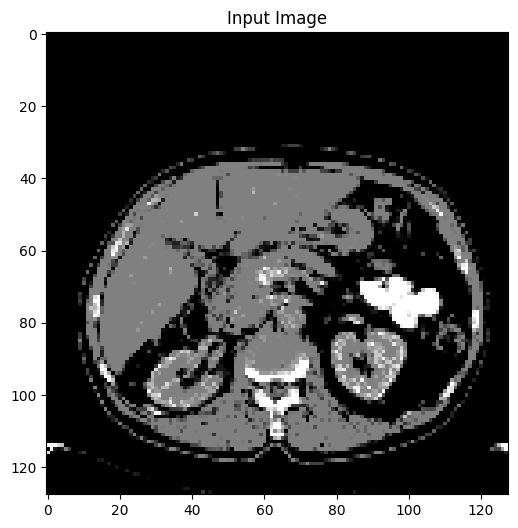

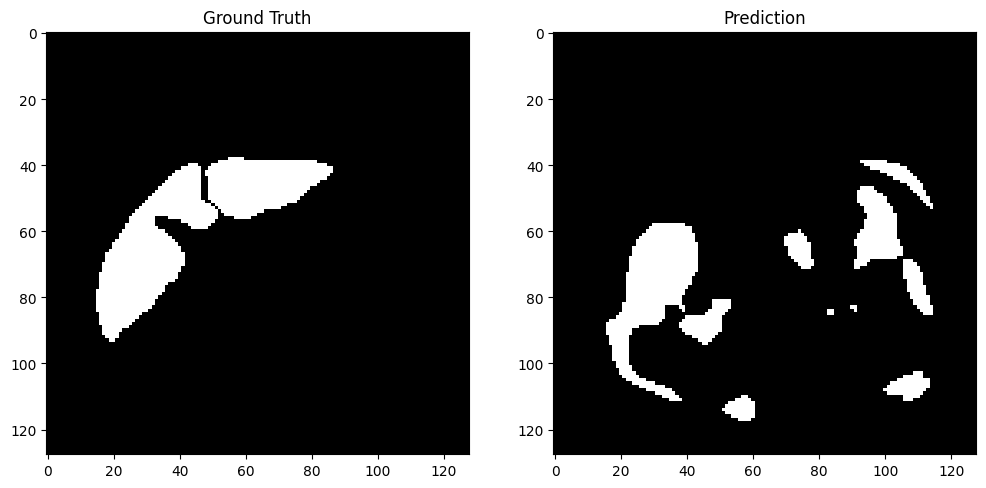

In [46]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth"
visualize_results(model, val_loader, weight_path, num_images, device)